# Clustering Data Time Series Harga Bahan Pangan 

Data yang digunakan adalah data **Harian**, bertujuan untuk mengetahui perbedaan model pada data harian dan mingguan.

## Import Library

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import seaborn as sns

from scipy.interpolate import interp1d
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.stats import pearsonr
from itertools import combinations

from sklearn.manifold import MDS

import skfuzzy as fuzzy

## Load Data

In [2]:
data = pd.read_csv('Data/csv/HargaBahanPangan2020-2024.csv')
drop_columns = ['Beras', 'Bawang Merah', 'Bawang Putih', 'Cabai Merah', 'Cabai Rawit', 'Daging Sapi', 
                'Telur Ayam', 'Daging Ayam', 'Minyak Goreng', 'Gula Pasir']
data = data.drop(drop_columns, axis=1)
# Dataset asli tanpa imputasi dan interpolasi
data.head(5)

,Komoditas (Rp),Beras Kualitas Medium I,Bawang Merah Ukuran Sedang,Bawang Putih Ukuran Sedang,Cabai Merah Keriting,Cabai Rawit Merah,Daging Sapi Kualitas 1,Telur Ayam Ras Segar,Daging Ayam Ras Segar,Minyak Goreng Kemasan Bermerk 1,Gula Pasir Lokal
0,1/1/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/1/2020,12150.0,39250.0,32250.0,67500.0,59100.0,121250.0,25900.0,37100.0,13450.0,13200.0
2,3/1/2020,12200.0,38900.0,31100.0,63000.0,60850.0,121250.0,25850.0,37100.0,13500.0,13200.0
3,6/1/2020,12250.0,36650.0,31250.0,64250.0,76150.0,121250.0,25650.0,35850.0,13500.0,13200.0
4,7/1/2020,12250.0,34600.0,31400.0,63600.0,64150.0,121250.0,25600.0,35900.0,13550.0,13350.0


## Exploratory Data
1. Mengganti nama kolom menjadi nama general
2. Mengubah tipe data fitur Komoditas (Rp) menjadi datetime
3. Mengecek nilai yang kosong
4. Mengecek nilai outlier
5. Visualisasi menggunakan diagram garis

### Mengganti nama kolom menjadi nama general

In [3]:
data = data.rename(columns={'Komoditas (Rp)':'Tanggal', 'Beras Kualitas Medium I': 'Beras', 'Bawang Merah Ukuran Sedang':'Bawang Merah',
                            'Bawang Putih Ukuran Sedang':'Bawang Putih', 'Cabai Merah Keriting': 'Cabai Merah', 'Cabai Rawit Merah':'Cabai Rawit', 
                            'Daging Sapi Kualitas 1':'Daging Sapi', 'Telur Ayam Ras Segar':'Telur Ayam', 'Daging Ayam Ras Segar':'Daging Ayam',
                           'Minyak Goreng Kemasan Bermerk 1':'Minyak Goreng', 'Gula Pasir Lokal':'Gula Pasir'})
data.head(5)

,Tanggal,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir
0,1/1/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/1/2020,12150.0,39250.0,32250.0,67500.0,59100.0,121250.0,25900.0,37100.0,13450.0,13200.0
2,3/1/2020,12200.0,38900.0,31100.0,63000.0,60850.0,121250.0,25850.0,37100.0,13500.0,13200.0
3,6/1/2020,12250.0,36650.0,31250.0,64250.0,76150.0,121250.0,25650.0,35850.0,13500.0,13200.0
4,7/1/2020,12250.0,34600.0,31400.0,63600.0,64150.0,121250.0,25600.0,35900.0,13550.0,13350.0


### Mengubah fitur Tanggal menjadi datetime

In [4]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format="%d/%m/%Y")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tanggal        1305 non-null   datetime64[ns]
 1   Beras          1255 non-null   float64       
 2   Bawang Merah   1255 non-null   float64       
 3   Bawang Putih   1255 non-null   float64       
 4   Cabai Merah    1255 non-null   float64       
 5   Cabai Rawit    1255 non-null   float64       
 6   Daging Sapi    1255 non-null   float64       
 7   Telur Ayam     1255 non-null   float64       
 8   Daging Ayam    1255 non-null   float64       
 9   Minyak Goreng  1255 non-null   float64       
 10  Gula Pasir     1255 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 112.3 KB


### Mengecek nilai yang kosong atau missing value

In [5]:
print('Jumlah Data yang kosong')
data.isnull().sum()

Jumlah Data yang kosong


Tanggal           0
Beras            50
Bawang Merah     50
Bawang Putih     50
Cabai Merah      50
Cabai Rawit      50
Daging Sapi      50
Telur Ayam       50
Daging Ayam      50
Minyak Goreng    50
Gula Pasir       50
dtype: int64

Pada masing-masing fitur memiliki banyak missing value. Terjadi karena pada akhir pekan dan hari libur nasional tidak dilakukan input nilai ke sistem, terutama data yang digunakan merupakan data harian. Rasio jumlah data dan nilai kosong adalah 
<div>
<div style="text-align: center;">
    <img src="https://latex.codecogs.com/png.image?\dpi{120} \frac{50}{1255} \times 100\% = 3.98\% \approx 4\%" alt="Ratio Missing Value">
</div>
</div>

Jumlah data yang kosong, ~4% dan data valid sebesar 95% di mana termasuk rendah dan masih dapat diatasi menggunakan teknik imputasi. Pada penelitian ini, data akan ditransformasi menjadi bentuk mingguan, setelahnya data yang kosong akan diisi mennggunakan metode backward fill. Pada visualisasi _time-series_ di atas, pola juga masih terlihat dengan banyak fluktuasi.

In [6]:
data.describe().round(2)

,Tanggal,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir
count,1305,1255.00,1255.00,1255.00,1255.00,1255.00,1255.00,1255.00,1255.00,1255.00,1255.00
mean,2022-07-01 19:12:00,12963.78,36366.02,32917.45,45491.16,55206.77,135114.86,26270.80,37447.85,17923.63,15163.35
min,2020-01-01 00:00:00,11400.00,21400.00,20250.00,20350.00,22500.00,121250.00,18350.00,31100.00,13200.00,12950.00
25%,2021-04-01 00:00:00,11700.00,30250.00,26500.00,32400.00,38300.00,132500.00,24250.00,35900.00,15400.00,13700.00
50%,2022-07-01 00:00:00,12400.00,34400.00,29850.00,42100.00,49000.00,137500.00,26350.00,37250.00,18500.00,14700.00
75%,2023-10-02 00:00:00,14500.00,41125.00,40150.00,54500.00,69200.00,141650.00,28150.00,38750.00,19400.00,17100.00
max,2024-12-31 00:00:00,16850.00,73600.00,59000.00,126400.00,134500.00,165850.00,32600.00,46100.00,24750.00,18900.00
std,NaN,1409.43,9214.59,7451.49,17996.34,23510.57,7907.35,3101.36,2355.44,2786.25,1764.87


Insight:
1. **Beras : Beras Kualitas Medium**, rata-rata harga beras adalah Rp12.963 atau sekitar Rp13.000. Persebaran harganya dimulai dari Rp11.400 hingga Rp16.850, tidak menunjukkan selisih dan persebaran yang terlalu besar.
2. **Bawang Merah : Bawang Merah Ukuran Sedang**, rata-rata harga bawang merah per-kilogram mencapai Rp36.366. Persebaran harganya dimulai dari Rp21.400 hingga Rp73.600. Rentang harga menunjukkan nilai yang tinggi dan terdapat variasi harga yang cukup tinggi.
3. **Bawang Putih : Bawang Putih Ukuran Sedang**, rata-rata harga bawahng putih per-kilogram mencapai Rp32.917 atau sekitar Rp33.000. Persebaran harga dimulai dari Rp20.250 hingga Rp59.000 dengan persebaran sedang yang tidak terlalu tinggi.
4. **Cabai Merah : Cabai Merah Keriting**, rata-rata harga cabai merah per-kilogram mencapai harga Rp45.491. Persebaran harga dimulai dari Rp20.350 hingga Rp126.400 dengan nilai standar deviasi sebesar 17.996 menunjukkan persebaran harga lebih tinggi dan mengindikasikan bahwa komoditas ini memiliki harga yang fluktuatif.
5. **Cabai Rawit : Cabai Rawit Merah**, rata-rata harga cabai rawit merah menunjukkan harga Rp55.206. Persebaran harga dimulai dari RpRp22500 hingga Rp134500, jarak kedua harga mencapai Rp112.00 dan standar deviasi mencapai Rp23.510. Termasuk persebarannya tinggi dan dikhawatirkan harga sangat fluktuatif.
6. **Daging Sapi : Daging Sapi Kualitas 1**, rata-rata harga daging sapi mencapai Rp135.114. Persebaran harga dimulai dari Rp121.250 hingga Rp165.850. Meskipun harga daging sapi termasuk tinggi, tetapi persebarannya tidak terlalu tinggi dengan standar deviasi mencapai 7.907. Nilai rata-rata lebih denat dengan Q1 di mana harga cenderung rendah.
7. **Telur Ayam : Telur Ayam Ras Segar**, rata-rata harga telur ayam mencapai Rp26.270 dengan persebaran mulai Rp18.350 hingga Rp32.600. Nilai rata-rata lebih dekat dengan nilai Q3, artinya data menyebar di atas nilai rata-rata.
8. **Daging Ayam : Daging Ayam Ras Segar**, rata-rata harga daging ayam per-kilogram mencapai Rp37.477 dengan persebaran mulai Rp31.100 hingga Rp46.100. (belum paham nih sama daging ayam gimana.
9. **Minyak Goreng : Minyak Goreng Kemasan Bermerk 1**, harga rata-rata minyak goreng bermerk Rp17.923 atau sekitar Rp18.000 dengan rentang mulai Rp13.200 hingga Rp24.750. Dilihat dari nilai Q3, Q2, dan Q1 menunjukkan bahwa harga minyak goreng bermerk tersebar ke atas.
10. **Gula Pasir : Gula Pasir Lokal**, rata-rata harga bahan pangan mencapai Rp15.163 per-kilogramnya. Rentang harga mulai dari Rp12.950 hingga Rp18.900 dan simpangan baku 1.764 menunjukkan bahwa sebaran harga Gula Pasir Lokal cenderung stabil  dan merata ke atas.

### Mengecek nilai outlier
Pengecekan ini digunakan teknik visualisai boxplot

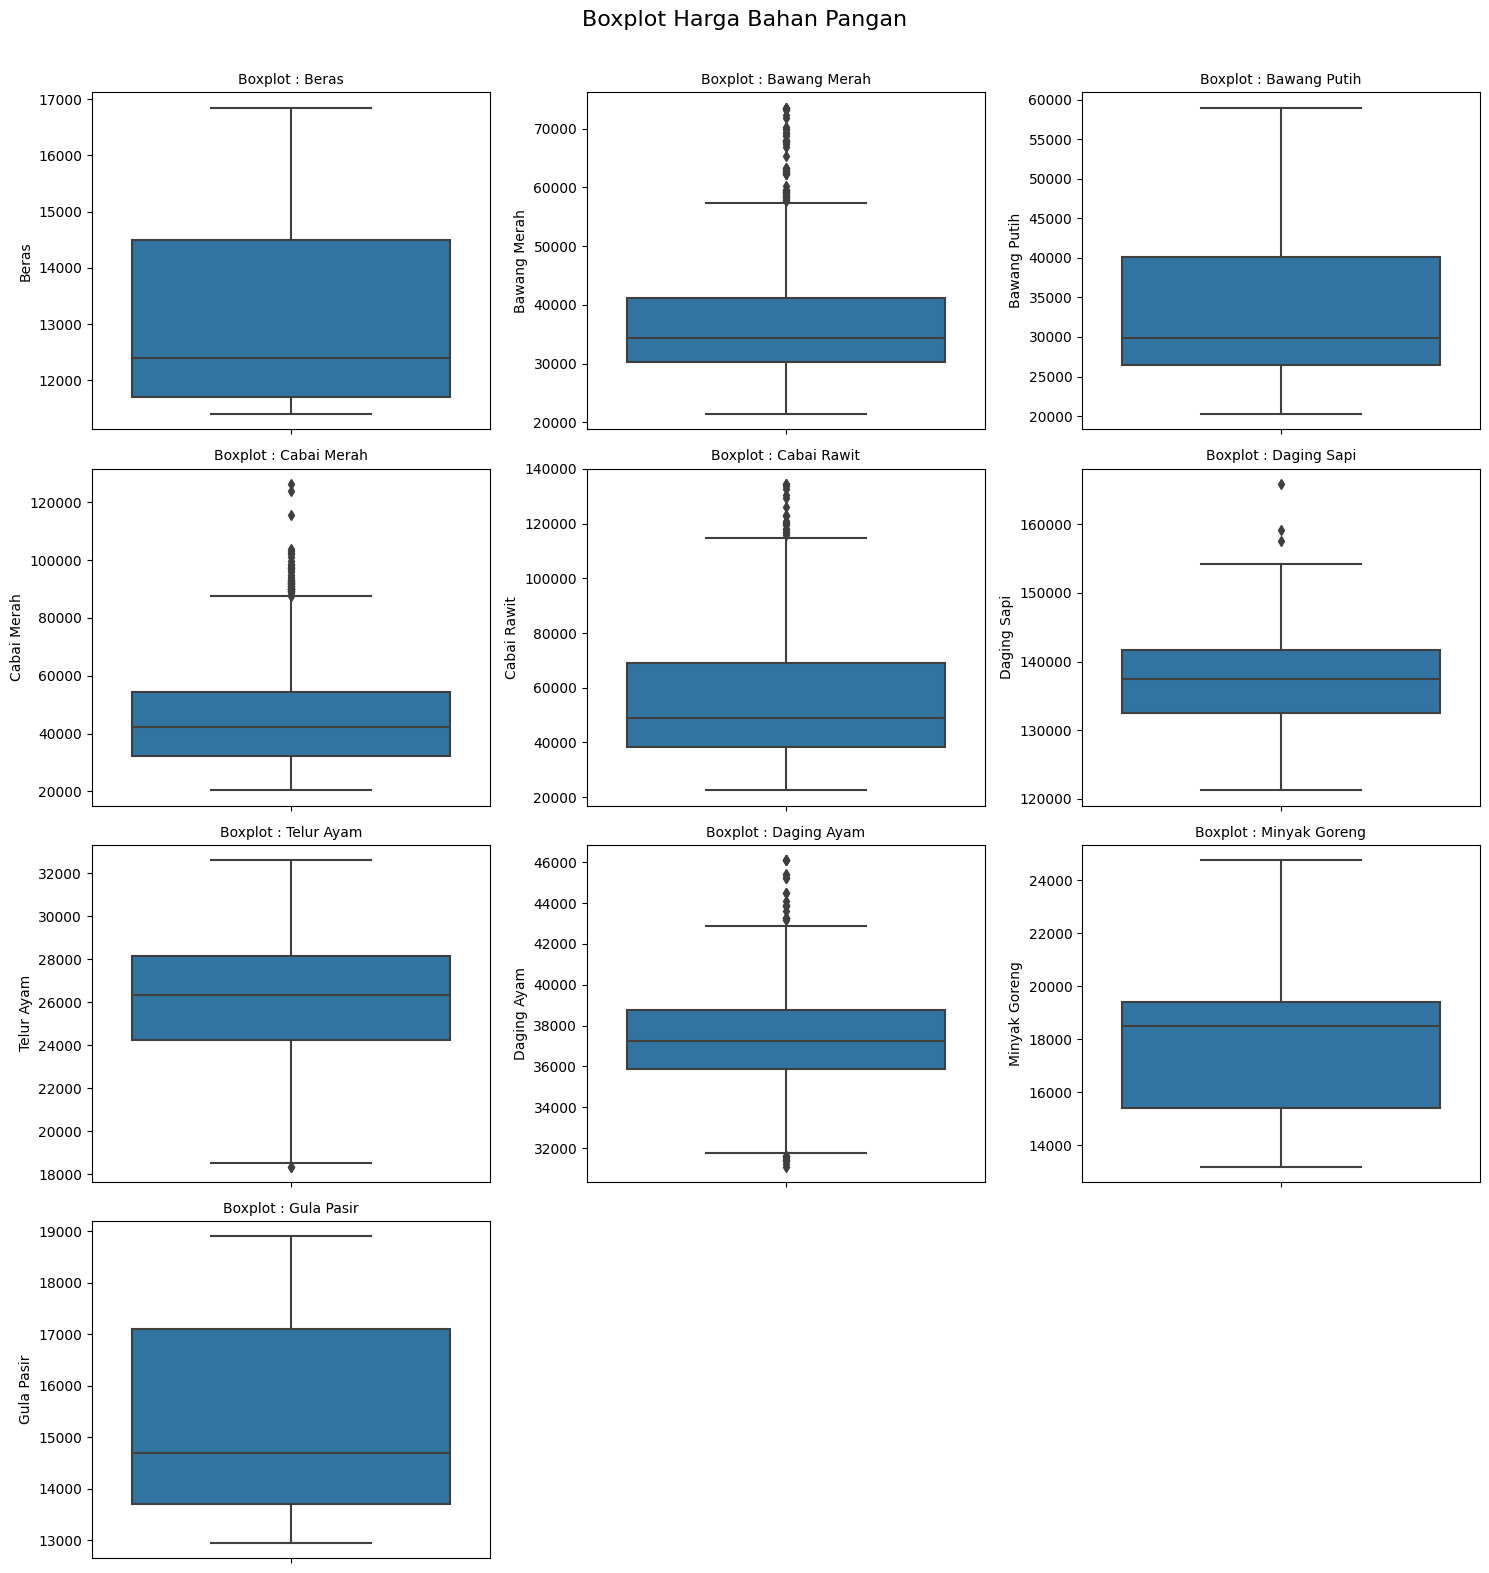

In [7]:
def visualisasi_boxplot(data, drop_col, title):
    data_vis = data.drop(drop_col, axis=1).copy() # Variabel ini khusus untuk visualisasi, supaya variabel tanggal tidak terbawa divisualisasikan.
    
    # Visualisasi Boxplot Harga Bahan Pangan
    n = len(data_vis.columns)
    
    # Ukuran grid
    cols = 3
    rows = math.ceil(n/cols)
    
    # Buat plot
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()
    
    for i, col in enumerate(data_vis.columns):
        sns.boxplot(y=data_vis[col], ax=axes[i])
        axes[i].set_title(f'Boxplot : {col}', fontsize=10)
    
    # Hapus subplot yang kosong
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Sisakan ruang untuk suptitle
    plt.suptitle(title, fontsize=16)
    plt.show()

visualisasi_boxplot(data, ['Tanggal'], 'Boxplot Harga Bahan Pangan')

insight:
1. Hampir semua fitur memiliki sebaran data mayoritas di atas nilai rata-rata. Kecuali pada fitur Minyak Goreng Bermerk 1, sebaran harganya di bawah nilai rata-rata dan Daging Sapi meskipun memiliki beberapa nilai outlier ke atas.
2. Terdapat beberapa fitur yang memiliki outlier di atas, yaitu Bawang Merah, Cabai Merah, Cabai Rawit, dan Daging Sapi, Telur Ayam dengan sedikit outlier di bawah, dan Daging Ayam dengan outlier di atas dan di bawah.

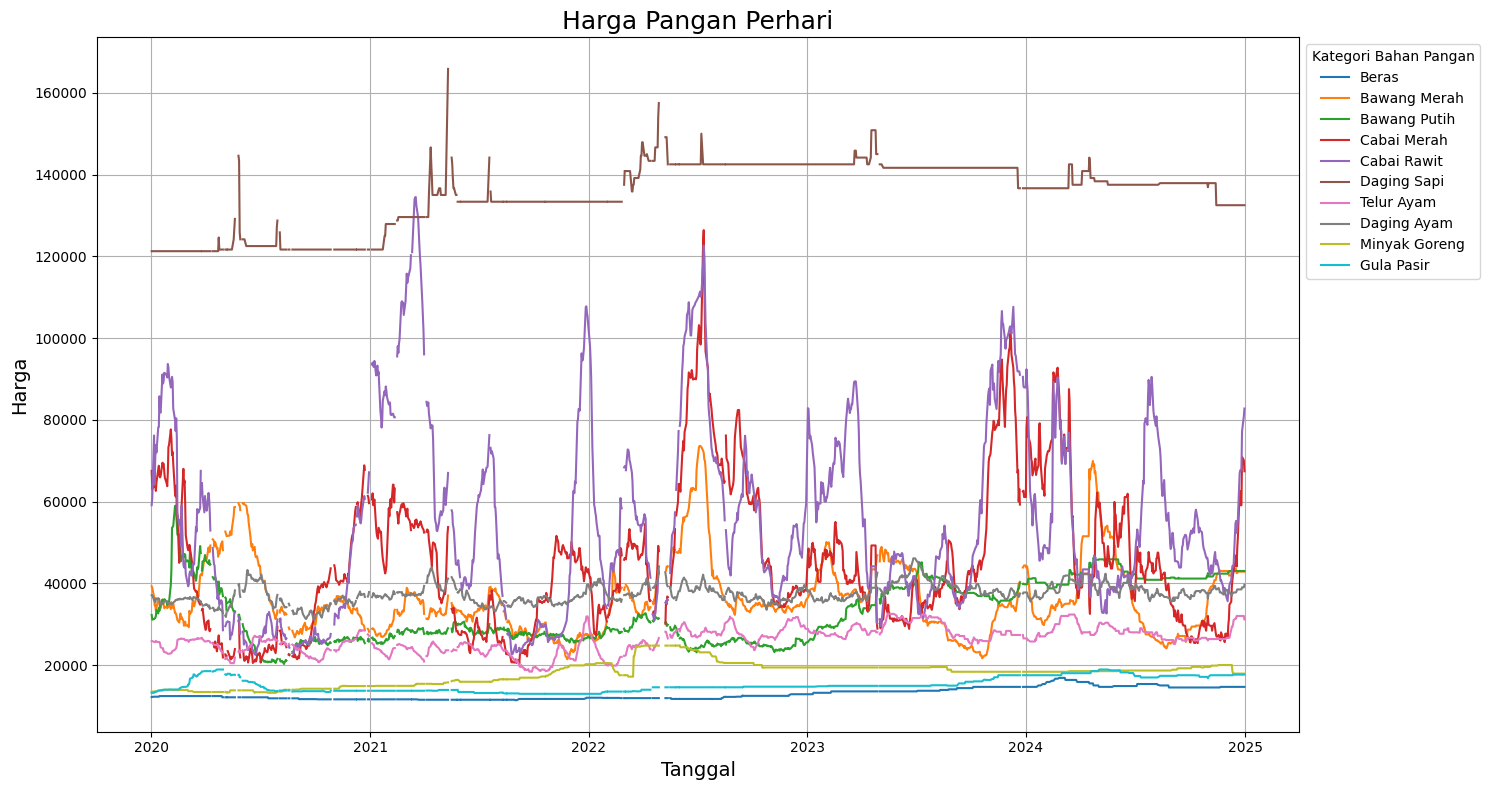

In [8]:
def diagramGarisVis(df, datetime_col, label_name=None, title="Diagram Garis Harga Bahan Pangan"):
    """
    Visualisasi Diagram Garis Harga Bahan Pangan.
    
    Parameters:
    - df: DataFrame berisi data harga
    - datetime_col: nama kolom untuk sumbu x (string)
    - label_name: label untuk legend, default-nya adalah nama-nama kolom selain datetime_col
    - title: judul grafik
    """
    figure(figsize=(15, 8), dpi=100)

    data_vis = df.drop(columns=[datetime_col])
    if label_name is None:
        label_name = drop_columns

    for col, label in zip(data_vis.columns, label_name):
        plt.plot(df[datetime_col], df[col], label=label)

    plt.legend(title='Kategori Bahan Pangan', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title, fontsize=18)
    plt.xlabel(datetime_col, fontsize=14)
    plt.ylabel('Harga', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

diagramGarisVis(data, datetime_col='Tanggal', title='Harga Pangan Perhari')

Insight.
1. Data yang kosong mempengaruhi pola pada data.
2. Data Cabai Rawit, Cabai Merah, dan Bawang Merah dengan pola fluktuatif ekstrim.
3. Harga Daging Sapi memiliki harga yang peling tinggi dan cenderung stabil.
4. Pola fluktuasi harga bahan pangan di akhir tahun dan awal tahun cenderung meningkat dan tidak stabil.
5. Fluktuasi harga yang paling tinggi terjadi pada awal tahun 2021 dan pertengahan tahun 2022.

## Data Preparation
Langkah-langkah yang dilakukan:
1. Menambahkan fitur tahun
2. Transformasi data ke bentuk mingguan
3. Normalisasi Data
4. Transpose Data
5. Modeling Dynamic Time Warping (DTW)
6. Reduksi Data menggunakan Multidimensional Scaling (MDS)

### Menambah Fitur Tahun
Dilakukan agar lebih mudah menganalisis data

In [9]:
# Menambahkan fitur tahun
data['Tahun'] = data['Tanggal'].dt.year
data.head()

,Tanggal,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,2020-01-02,12150.0,39250.0,32250.0,67500.0,59100.0,121250.0,25900.0,37100.0,13450.0,13200.0,2020
2,2020-01-03,12200.0,38900.0,31100.0,63000.0,60850.0,121250.0,25850.0,37100.0,13500.0,13200.0,2020
3,2020-01-06,12250.0,36650.0,31250.0,64250.0,76150.0,121250.0,25650.0,35850.0,13500.0,13200.0,2020
4,2020-01-07,12250.0,34600.0,31400.0,63600.0,64150.0,121250.0,25600.0,35900.0,13550.0,13350.0,2020


### Agregasi Data
Perubahan bentuk data dari data harian menjadi data mingguan

In [10]:
data.dtypes

Tanggal          datetime64[ns]
Beras                   float64
Bawang Merah            float64
Bawang Putih            float64
Cabai Merah             float64
Cabai Rawit             float64
Daging Sapi             float64
Telur Ayam              float64
Daging Ayam             float64
Minyak Goreng           float64
Gula Pasir              float64
Tahun                     int32
dtype: object

In [11]:
# Urutkan berdasarkan tanggal
data_mingguan = data.sort_values(by='Tanggal').reset_index(drop=True)

# Membuat minggu di kolom pertama
data_mingguan['Minggu ke'] = None
data.loc[data['Tanggal'].between("2020-01-01", "2020-01-03"), "Minggu ke"] = 1

# Filter hari kerja
data_sisa = data.loc[data_mingguan['Minggu ke'].isna() & data['Tanggal'].dt.weekday<5].copy()

# Hitung minggu ke berdasarkan hari kerja setelah 3 Januari 2020
data_sisa['Minggu ke'] = ((data_sisa['Tanggal'] - pd.Timestamp("2020-01-06")).dt.days // 7) +2

# gabungkan kembali data
data_mingguan.update(data_sisa)

data_mingguan['Tahun'] = data['Tanggal'].dt.year
data_mingguan.to_csv('Data/csv/cek minggu.csv')

data_mingguan["Minggu ke"] = data_mingguan["Minggu ke"].astype("Int64")

data_mingguan = data_mingguan.drop(columns=['Tanggal'])
# Hitung rata-rata per minggu, otomatis mengabaikan NaN
data_mingguan = data_mingguan.groupby("Minggu ke").agg(lambda x: x[x > 0].mean(skipna=True)).reset_index()

# dat_min
data_mingguan

,Minggu ke,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
0,1,12175.0,39075.0,31675.0,65250.0,59975.0,121250.0,25875.0,37100.0,13475.0,13200.0,2020.0
1,2,12250.0,34640.0,31930.0,63870.0,71350.0,121250.0,25700.0,35910.0,13540.0,13380.0,2020.0
2,3,12340.0,35100.0,33810.0,67030.0,81180.0,121250.0,25290.0,35640.0,13730.0,13780.0,2020.0
3,4,12400.0,34920.0,35690.0,68210.0,90470.0,121250.0,23570.0,35430.0,13870.0,13930.0,2020.0
4,5,12400.0,34360.0,35210.0,68520.0,91660.0,121250.0,22820.0,35260.0,13950.0,13960.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
257,258,14650.0,42560.0,42640.0,29960.0,37530.0,132500.0,26650.0,37990.0,20000.0,17500.0,2024.0
258,259,14650.0,43200.0,43000.0,40150.0,43340.0,132500.0,29670.0,37410.0,18840.0,17560.0,2024.0
259,260,14650.0,42970.0,43000.0,47230.0,54320.0,132500.0,31740.0,38130.0,17900.0,17650.0,2024.0
260,261,14650.0,42850.0,43000.0,62160.0,69400.0,132500.0,32000.0,38600.0,17900.0,17650.0,2024.0


In [12]:
data_mingguan[data_mingguan.isnull().any(axis=1)]

,Minggu ke,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
122,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0


Terdapat satu minggu kosong, artinya terdapat satu minggu penuh hari libur dan tidak ada pelaporan monitoring harga pangan. Harga yang kosong berada di minggu ke 123 dan pengisian data yang kosong akan diisi menggunakan nilai pada minggu sebelumnya (backward fill).

In [13]:
data_mingguan = data_mingguan.ffill().bfill()
data_mingguan[data_mingguan['Minggu ke'].between(120,125)]

,Minggu ke,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
119,120,11900.0,33825.0,30575.0,36312.5,43087.5,143350.0,24262.5,39150.0,24750.0,13950.0,2022.0
120,121,11900.0,35890.0,31120.0,32650.0,31800.0,144010.0,24060.0,39110.0,24750.0,14550.0,2022.0
121,122,11900.0,43262.5,31362.5,46087.5,40112.5,151237.5,25987.5,41725.0,24750.0,14550.0,2022.0
122,123,11900.0,43262.5,31362.5,46087.5,40112.5,151237.5,25987.5,41725.0,24750.0,14550.0,2022.0
123,124,11900.0,43600.0,29980.0,34780.0,35550.0,147160.0,27500.0,40560.0,24750.0,14550.0,2022.0
124,125,11800.0,46300.0,28700.0,40750.0,47437.5,142500.0,26975.0,37875.0,24750.0,14550.0,2022.0


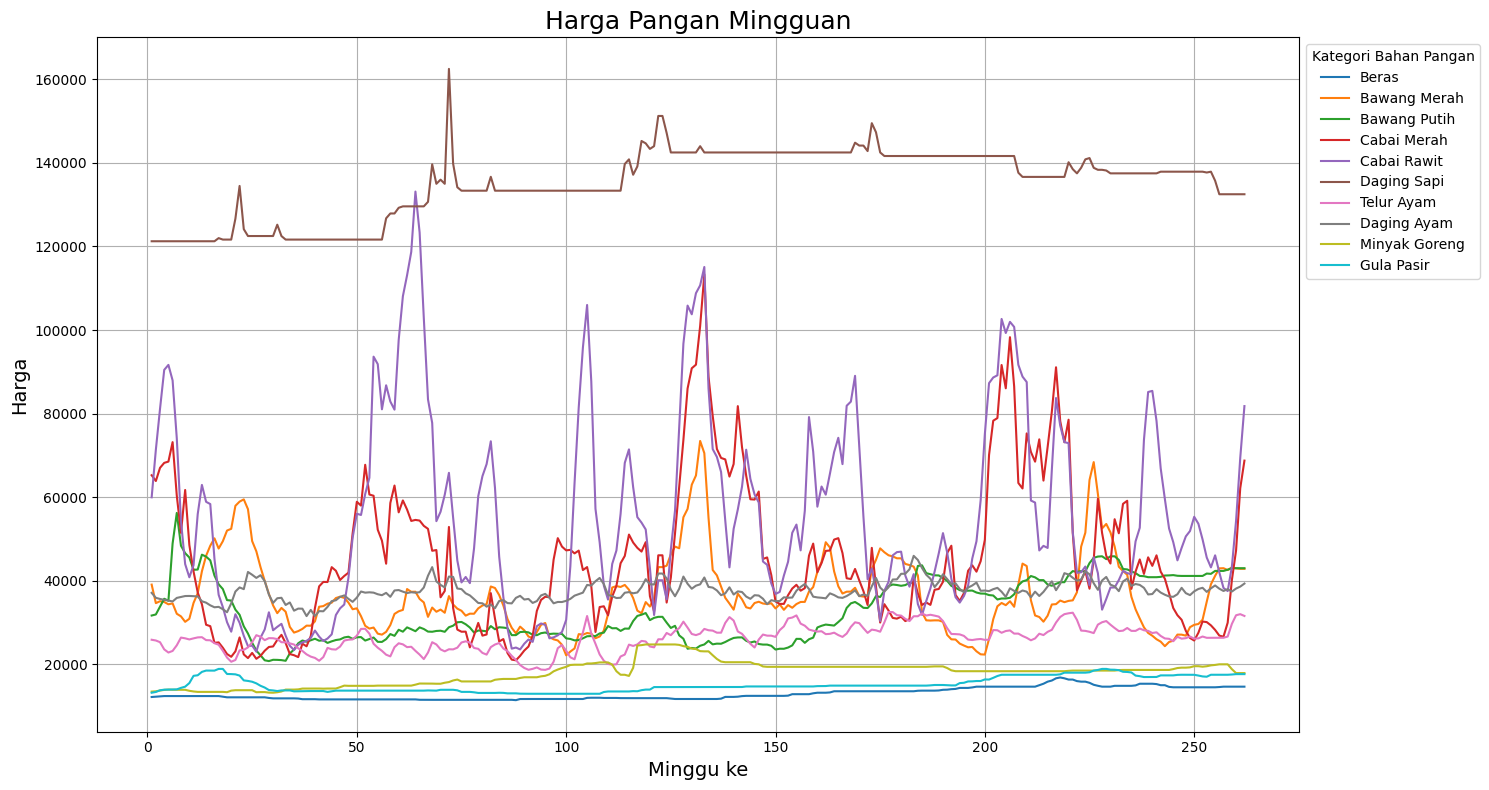

In [14]:
# Visualisasi Harga Bahan Pangan yang Sudah Ditransformasi ke bentuk mingguan
diagramGarisVis(data_mingguan, datetime_col='Minggu ke', title='Harga Pangan Mingguan')

Data yang kosong sudah terisi semua.

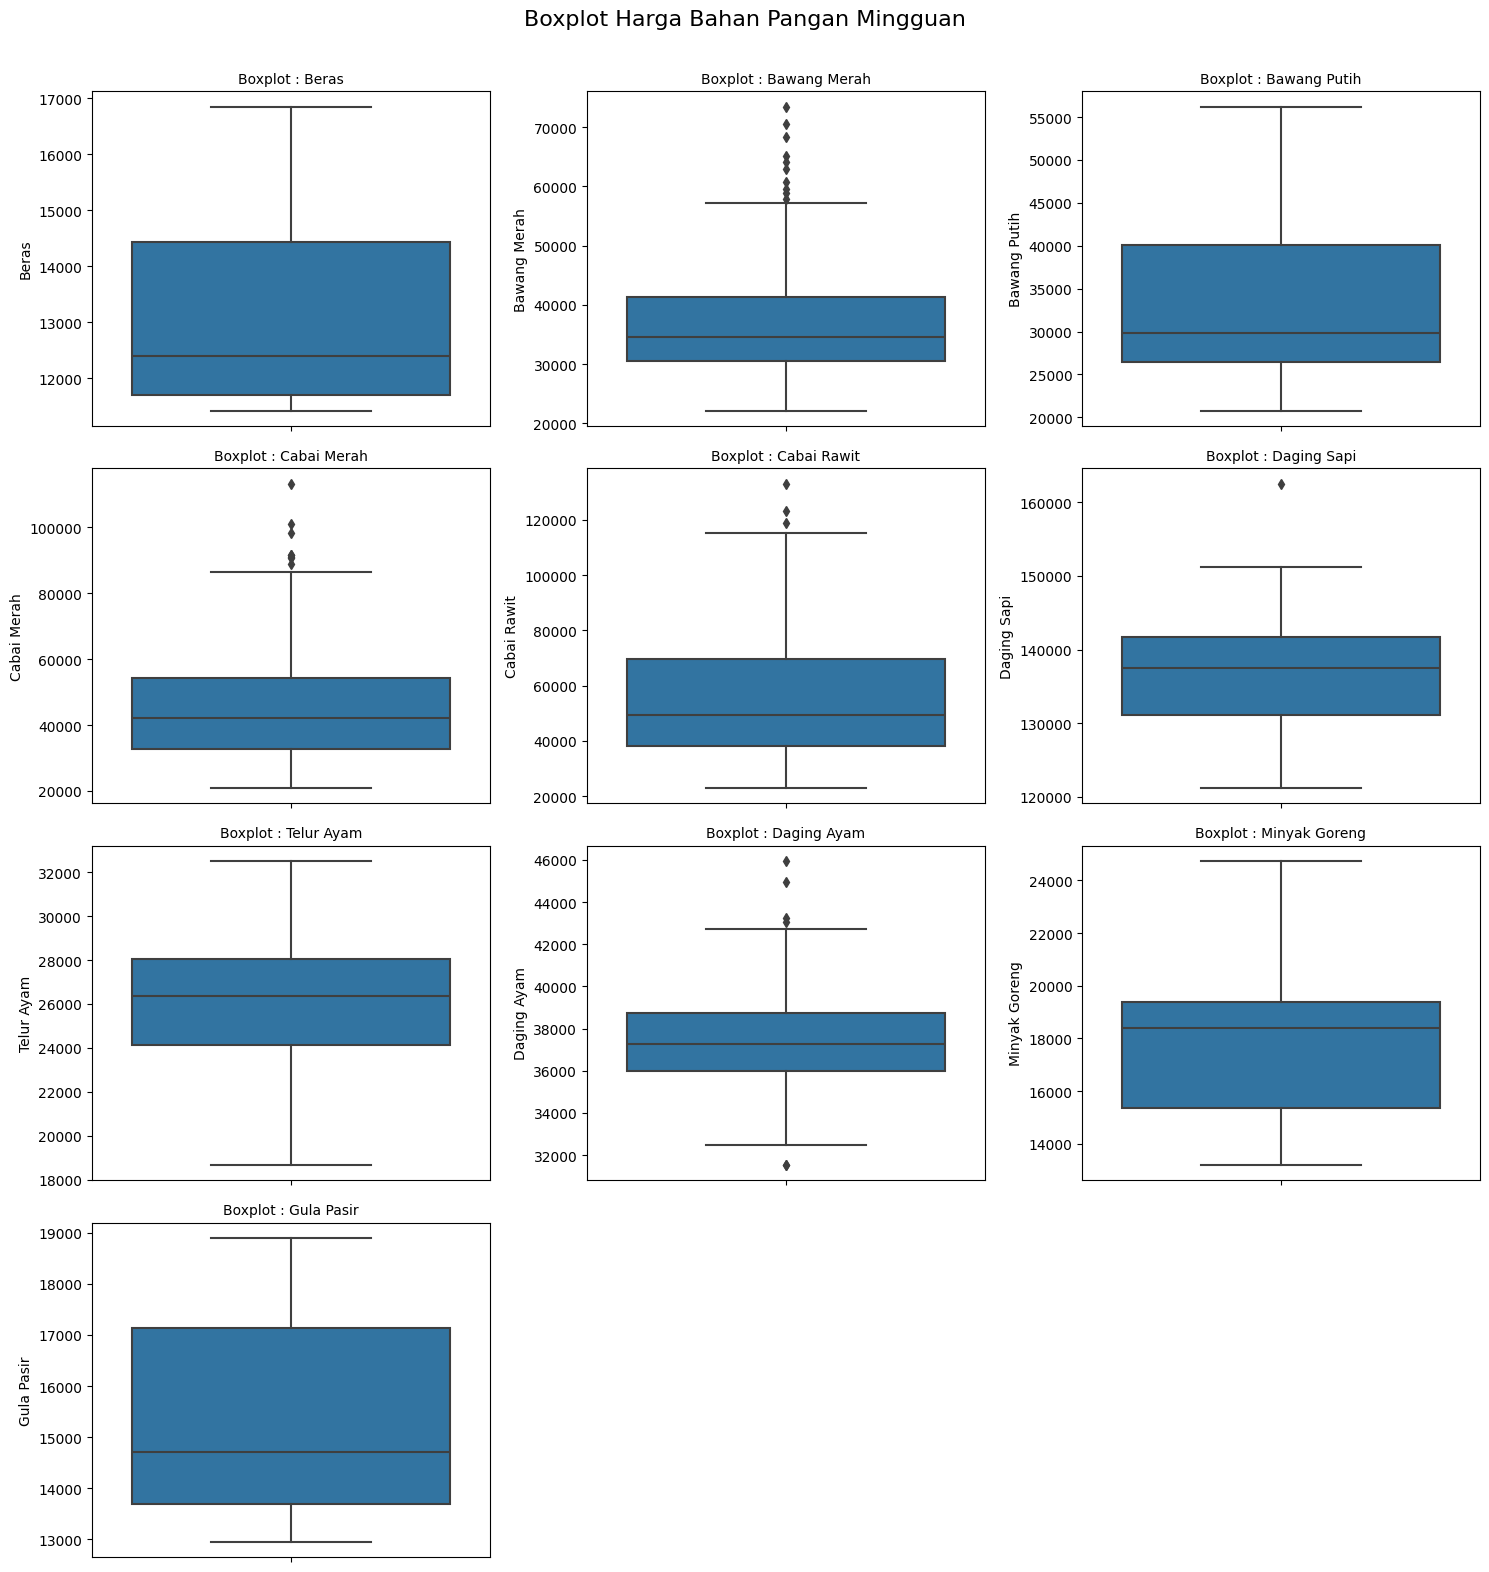

In [15]:
visualisasi_boxplot(data_mingguan, ['Minggu ke', 'Tahun'], 'Boxplot Harga Bahan Pangan Mingguan')

In [16]:
# Menampilkan dua angka di belakang koma
data_mingguan.describe().round(2)

,Minggu ke,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
count,262.0,262.00,262.00,262.00,262.00,262.0,262.00,262.00,262.00,262.00,262.00,262.00
mean,131.5,12927.84,36499.27,32822.95,45464.29,55082.1,135053.24,26227.20,37450.09,17892.60,15145.51,2022.00
std,75.78,1403.08,9167.18,7385.79,17809.16,23375.1,8082.53,3081.96,2313.47,2849.28,1766.43,1.42
min,1.0,11420.00,22150.00,20770.00,20960.00,23030.0,121250.00,18675.00,31540.00,13200.00,12950.00,2020.00
25%,66.25,11700.00,30480.00,26432.50,32685.00,38295.0,131135.00,24134.38,35966.88,15357.50,13700.00,2021.00
50%,131.5,12400.00,34565.00,29785.00,42185.00,49330.0,137500.00,26340.00,37255.00,18395.00,14700.00,2022.00
75%,196.75,14440.00,41400.00,40102.50,54378.12,69572.5,141650.00,28047.50,38745.00,19400.00,17145.00,2023.00
max,262.0,16850.00,73460.00,56230.00,113310.00,133140.0,162500.00,32520.00,45960.00,24750.00,18900.00,2024.00


Setelah dilakukan agregasi data harian menjadi data mingguan, diperoleh total 262 minggu observasi dengan minggu terakhir Desember 2024. Proses agregasi ini membantu dalam mengurangi noise pada data harian tanpa menghilangkan pola atau informasi penting dalam tren data.

Rangkuman statistik harga bahan pangan di atas:
1. **Beras**
     - Harga Beras per kilogram berkisar antara Rp11.420 - Rp16.850.
     - Rata-rata harga mencapai Rp12.927.
     - Memiliki variasi yang paling kecil diantara semua komoditas, ditandai dengan nilai standar deviasi terendah, menunjukkan harga yang relatif stabil dari minggu ke minggu.
2. **Bawang Merah**
    - Harga Bawang Merah per kilogram berkisar antara Rp22.150 - Rp73.460.
    - Rata-rata harga mencapai Rp36.499.
    - Memiliki rentang harga dan variasi yang tinggi, mencerminkan harga cenderung fluktiatif ditunjukkan dengan nilai rentang dan standar deviasi yang tinggi.
3. **Bawang Putih**
    - Harga Bawang Putih per kilogram berkisar antara Rp20.770 - Rp56.230.
    - Rata-rata harga mencapai Rp32.822.
    - Memiliki pola yang fluktuatif, ditandai dengan nilai rentang dan standar deviasi yang tinggi, namun lebih rendah dibandingkan Bawang Merah.
4. **Cabai Merah**
    - Harga Cabai Merah per kilogram berkisar antara Rp20.960 - Rp113.310.
    - Rata-rata harga mencapai Rp45.464.
    - Perubahan harga menunjukkan fluktuasi yang tinggi; ditandari dengan nilai rentang dan standar deviasi yang tinggi, dapat mencerminkan harga komoditas sensitif kepada pasokan dan musiman.
5. **Cabai Rawit**
    - Harga Cabai Rawit per kilogram berkisar antara Rp23.030 - Rp133.140.
    - Rata-rata harga mencapai Rp55.082.
    - Perubahan harga menunjukkan fluktuasi yang sangat tinggi; ditunjukkan dengan nilai rentang dan standar deviasi yang paling tinggi diantara semua komoditas.
6. **Daging Sapi**
    - Harga Daging Sapi per kilogram berkisar antara Rp121.250 - Rp165.500.
    - Rata-rata harga mencapai Rp135.053.
    - Harga komoditas Daging Sapi cukup tinggi namun stabil, dengan dengan kenaikan harga terjadi secara sewaktu waktu.
7. **Telur Ayam**
    - Harga komoditas Telur Ayam per kilogram berkisar antara Rp18.675 hingga Rp32.520.
    - Rata-rata harga mencapai Rp26.227.
    - Harga Telur Ayam cenderung berada di rentang bawah, dekat dengan nilai Q1, menunjukkan kestabilan relatif meskipun mengalami fluktuasi ringan.
8. **Daging Ayam**
    - Harga Daging Ayam per kilogram berkisar antara Rp31.540 - Rp45.960.
    - Rata-rata harga mencapai Rp37.450.
    - Nilai rentang dan variasi yang ditunjukkan cukup rendah, dengan pola fuktuasi lebih terkendali.
9. **Minyak Goreng**
    - Harga Minyak Goreng per kilogram berkisar antara Rp13.200 - Rp24.740.
    - Rata-rata harga mencapai Rp17.892.
    - Harga Minyak goreng perliter berada di antara rentang bawah, yaitu di antara Q1 dan Q2 (median), artinya lebih banyak data berada di bawah nilai median dengan beberapa lonjakan harga yang bersifat insidental (terjadi di waktu tertentu saja, tidak rutin dan bertahap).
10. **Gula Pasir**
    - Harga Gula Pasir per kilogram berkisar antara Rp12.950 - Rp18.900.
    - Rata-rata harga mencapai Rp15.145.
    - Termasuk harga dengan standar deviasi rendah setelah beras dan nilai rentang kecil, menunjukkan kestabilan harga selama observasi.

Kesimpulan awal dari data statistik data mingguan:
- Data mingguan berhasil mendapatkan pola fluktuasi harian tanpa menghilangkan tren utama.
- Komoditas Cabai Merah dan Cabai Rawit merupakan komoditas dengan fluktuasi ekstrem, sedangkan Beras dan Gula Pasir cenderung stabil.
- Beberapa komoditas bahan pangan (seperti Daging Sapi, Telur Ayam, dan Minyak Goreng) memiliki distribusi harga yang condong ke bawah, ditunjukkan dengan rata-rata komoditas yang berada di dekat atau di bawah Q2 atau median.

### Normalisasi Data

Normalisasi data dilakukan untuk mentransformasi data asli menjadi rentang 0 sampai 1, sehingga data sebelum dan sesudah dinormalisasi memiliki perbandingan yang seimbang. Hasilnya, antar variabel memiliki skala yang sama dengan rumus:

<div>
<div style="text-align: center;">
    <img src="https://latex.codecogs.com/png.image?\dpi{120}&space;\text{Min-Max}=\frac{X-X[min]}{X[max]-X[min]}" alt="Ratio Missing Value">
</div>
</div>

Dimana $X$ merupakan baris pada fitur yang akan dinormalisasi.

In [17]:
def MinMaxScaling(df, col=drop_columns):
    """ Fungsi untuk standarisasi data pada masing-masing harga pangan
    Parameter:
    df : DataFrame yang berisi harga pangan
    col : kolom yang akan distandarisasi (list)
    """
    data_scaled = df.copy()
    data_scaled[col] = (df[col] - df[col].min(axis=0)) / (df[col].max(axis=0) - df[col].min(axis=0))
    return data_scaled

data_scaled = MinMaxScaling(data_mingguan)
data_scaled

,Minggu ke,Beras,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Daging Sapi,Telur Ayam,Daging Ayam,Minyak Goreng,Gula Pasir,Tahun
0,1,0.139042,0.329858,0.307530,0.479589,0.335528,0.000000,0.520043,0.385576,0.023810,0.042017,2020.0
1,2,0.152855,0.243422,0.314721,0.464645,0.438834,0.000000,0.507403,0.303051,0.029437,0.072269,2020.0
2,3,0.169429,0.252387,0.367738,0.498863,0.528108,0.000000,0.477790,0.284327,0.045887,0.139496,2020.0
3,4,0.180479,0.248879,0.420756,0.511640,0.612478,0.000000,0.353557,0.269764,0.058009,0.164706,2020.0
4,5,0.180479,0.237965,0.407219,0.514997,0.623286,0.000000,0.299386,0.257975,0.064935,0.169748,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
257,258,0.594843,0.397778,0.616751,0.097455,0.131686,0.272727,0.576020,0.447295,0.588745,0.764706,2024.0
258,259,0.594843,0.410251,0.626904,0.207796,0.184452,0.272727,0.794150,0.407074,0.488312,0.774790,2024.0
259,260,0.594843,0.405769,0.626904,0.284461,0.284170,0.272727,0.943662,0.457004,0.406926,0.789916,2024.0
260,261,0.594843,0.403430,0.626904,0.446129,0.421124,0.272727,0.962441,0.489598,0.406926,0.789916,2024.0


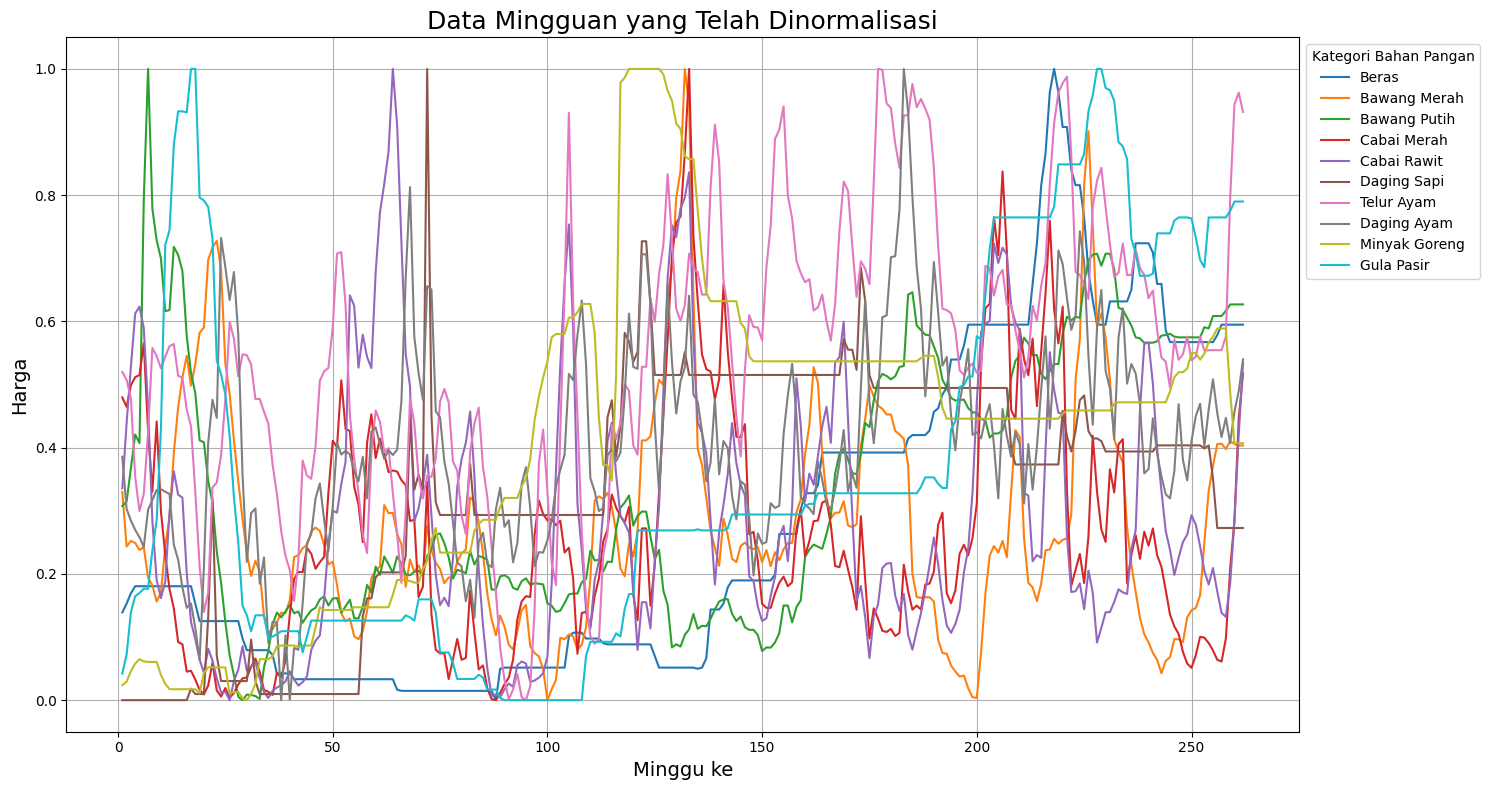

In [18]:
diagramGarisVis(data_scaled, datetime_col='Minggu ke', title='Data Mingguan yang Telah Dinormalisasi')

In [19]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Minggu ke      262 non-null    Int64  
 1   Beras          262 non-null    float64
 2   Bawang Merah   262 non-null    float64
 3   Bawang Putih   262 non-null    float64
 4   Cabai Merah    262 non-null    float64
 5   Cabai Rawit    262 non-null    float64
 6   Daging Sapi    262 non-null    float64
 7   Telur Ayam     262 non-null    float64
 8   Daging Ayam    262 non-null    float64
 9   Minyak Goreng  262 non-null    float64
 10  Gula Pasir     262 non-null    float64
 11  Tahun          262 non-null    float64
dtypes: Int64(1), float64(11)
memory usage: 24.9 KB


Data pada masing-masing kolom berada di rentang 0 hingga 1 dan bergerak sesuai polanya seperti sebelumnya. Jadi data seperti sedang dilakukan zoom in.

### Modeling Fuzzy C-Means (FCM) Menggunakan Kesamaan Jarak Dynamic Time Warping (DTW)

**Dynamic Time Warping (DTW)** adalah algoritma untuk membandingkan dua data time-series yang mungkin memiliki panjang yang berbeda. DTW bekerja dengan menyelaraskan deret waktu dengan "membengkokkan" (warping) salah satu deret waktu untuk menemukan jalur penyesuaian (warping path) yang terbaik yang meminimalkan perbedaan antara kedua deret waktu.

Dengan rumus:
<div>
<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;D_{i,j}=L_{i,j}+\min\left\{D_{i-1,j},D_{i,j-1},D_{i-1,j-1}\right\}" alt="Rumus DTW">
</div>
</div>

Dimana

$D_{i,j}$ : elemen($i,j$) dari cost matrix D.

$L_{i,j}$ : jarak kedua time-series di mana $L_{i,j} = |x_{i} - y_{j}|$

Adapun jarak DTW antar dua time-series $x$ dan $y$ didefinisikan sebagai persamaan:

<div>
<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;D_{DTW}(x,y)=D_{n,m}" alt="Jarak antara dua DTW">
</div>
</div>

**Algoritma Fuzzy C-Means (FCM) Clustering** merupakan algoritma soft clustering yang memodifikasi cara kerja K-Means Clustering dengan mengadaptasi derajat keanggotaan fuzzy logic sebagai hasil akhir nilai anggota cluster. Pengelompokannya didasarkan pada penetapan titik data dengan pusat cluster, cocok untuk data time-series dengan interval waktu yang sama. Langkah-langkah dari FCM, yaitu:
1. Inisiasi matriks dengan anggota derajat $U$ berupa matriks $m$x$n$. Dimana $m$ adalah atribut dari setiap data dan $n$ merupakan jumlah sampel data.
2. Menentukan kriteria berikut:
   - $c$: jumlah cluster.
   - $m$: fuzziness atau derajat fuzzy (biasanya 2).
   - $Maxiter$: maksimum iterasi.
   - $e$: error yang diharapkan.
3. **Tentukan nilai acak/random** 
   Dilakukan untuk mencari keanggotaan cluster dengan rumus:
    <div>
    <div align="center">
        <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;J=\sum_{i=1}^{n} \sum_{k=1}^{c} (u_{ik})^{m} d^{2} (v_{k}, x_{i})" alt="Rumus Keanggotaan DTW">
    </div>
    </div>
    
    Di mana:
    - $u_{ik}$: derajat keanggotaan dari time-series ke-$i$ pada cluster ke-$k$.
    - $d(v_k, x_i)$: jarak antara pusat cluster ke-k dan time-series ke-{i} dengan menggunakan jarak DTW.

5. **Menghitung centroid atau pusat cluster {v_k} Setiap Cluster**
  Centroid dihitung seperti pada umumnya, karena data merupakan time-series dilakukan dengan rata-rata fuzzy.
    <div>
    <div align="center">
        <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;v_k= \frac{\sum_{i=1}^{n} (u_{ik})^m x_i} {\sum_{n=1}^{i} (u_{ik})^{m}}" alt="Rumus Menghitung Centroid">
    </div>
    </div>

6. **Update matriks keanggotaan {u}**
   Perhitungan dilakukan menggunakan menggunakan rumus DTW
    <div>
    <div align="center">
        <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;{u_{ik}}=\frac{1}{\sum_{j=1}^{c}(\frac{d(v_k,x_i)}{d(v_j,x_i)})^{\frac{2}{m-1}}}" alt="Update matriks keanggotaan u">
    </div>
    </div>
    Semakin dekat $x_i$ ke centroid, maka nilai $u_{ik}$ akan semakin besar. Pada $d(v_k, x_i)$ merupakan persamaan jarak Dynamic Time Warping antara $x_i$ (data) dengan $v_k$ (centroid).

7. **Evaluasi konvergensi**  
   Evaluasi dilakukan dengan menghitung selisih matriks keanggotaan antara iterasi saat ini dan sebelumnya, hingga konvergen, yaitu jika:
   
   <div align="center">
     <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;\left\lVert U^{(t)}\,-\,U^{(t-1)}\right\rVert\;<\;\varepsilon" alt="Evaluasi konvergensi fuzzy c-means">
   </div>

   Jika perubahan sudah lebih kecil dari ambang batas $ε$ atau iterasi mencapai maksimum, maka proses dihentikan.

   **Hasil Cluster (Defuzzifikasi):**  
   Setelah proses FCM selesai, dilakukan defuzzifikasi untuk menentukan anggota cluster dari setiap data:  

   \[
   \text{Cluster}_i = \arg\max_j(u_{ji})
   \]

   Artinya, setiap data akan ditempatkan ke cluster dengan nilai keanggotaan terbesar.

In [54]:
from tqdm import tqdm

def initialize_membership(n_sampels, c):
    """
    Fungsi inisiasi membership (langkah 4)
    Parameter:
    - n_sampels: jumlah data
    - c: jumlah cluster
    Output:
    u: matriks keanggotaan
    """
    u = np.random.rand(c, n_sampels)
    u = u / np.sum(u, axis=0, keepdims=True)
    return u

def compute_centroids_dtw(data, u, m):
    """
    Fungsi menghitung centroid menggunakan kesamaan jarak DTW (dicoba update pakai euclidean distance)
    Parameter:
    - data: data time-series yang akan dihitung
    - u: keanggotaan matriks
    - m: derajat (fuzziness)
    Output:
    centorids: pusat cluster (v_k)
    """
    c = u.shape[0]
    centroids = []
    for j in range(c):
        weights = u[j] ** m
        weighted_sum = np.zeros_like(data[0])
        denominator = np.sum(weights)
        for i in range(len(data)):
            weighted_sum += weights[i] * data[i]
        centroid = weighted_sum / denominator
        centroids.append(centroid)
    return centroids

def compute_objective_function(u, centroids, data, m):
    """
    Fungsi objektif Fuzzy C-Means dengan DTW sebagai metrik jarak

    Parameter:
    - u: matriks keanggotaan (c x n)
    - centroids: array (c x t)
    - data: array (n x t)
    - m: derajat fuzziness
    Return: 
    - jm: nilai fungsi objektif
    """
    c, n = u.shape
    jm = 0.0
    for i in range(c):
        for k in range(n):
            dist = dtw.distance_fast(data[k], centroids[i])
            jm += (u[i][k] ** m) * (dist ** 2)
    return jm

def update_membership_dtw(data, centroids, m):
    """
    Fungsi update membership menggunakan kesamaan jarak DTW
    Parameter:
    - data: data time-series yang akan dihitung
    - centroids: pusat cluster
    - m: derajat fuzziness
    Output:
    - u_new: centroid baru yang sudah diperbarui
    """
    c = len(centroids)
    n = len(data)
    u_new = np.zeros((c, n))

    for i in range(n):
        for j in range(c):
            # d_ij = dtw.distance_fast(data[i], centroids[j]) + 1e-6 # Menghindari zero division
            # sum_term = 0
            # for k in range(c):
            #     d_ik = dtw.distance_fast(data[i], centroids[k]) + 1e-6
            #     sum_term += (d_ij / d_ik)** (2 / (m-1))
            denom = sum([(dtw.distance_fast(data[i], centroids[j], use_pruning=True) / dtw.distance_fast(data[i], centroids[k], use_pruning=True)) ** (2/(m-1))
                         for k in range(c)])
            u_new[j, i] = 1 / denom

    return u_new

def fcm_with_dtw_model(data, c, m, error, maxiter):
    """
    Fugsi model Fuzzy C-Means data time-series menggunakan kesamaan jarak Dynamic Time Warping dengan memanggil data sebelumnya
    Parameter:
    - data: data time-series
    - c: jumlah cluster
    - m: fuzziness (diatur 1.5)
    - error: batas toleransi error (diatur 1e-5 atau 0.00005)
    - maxiter: maksimal iterasi (diatur 100 kali perulangan)
    Output:
    """
    n_sampels = len(data)
    u = initialize_membership(n_sampels, c)
    jm_values = []

    jm = 0
    for iteration in tqdm(range(maxiter)):
        u_old = u.copy()
        centroids = compute_centroids_dtw(data, u, m)
        u = update_membership_dtw(data, centroids, m)
        jm = compute_objective_function(u, centroids, data, m)

        # Evaluasi Konvergensi
        if np.linalg.norm(u - u_old) < error:
            break
    
    # Mengubah centroids supaya menjadi 1 dimensi
    centroids = [np.ravel(c) for c in centroids]
    jm_values.append(jm)
    cluster_labels = np.argmax(u, axis=0) +1
    return centroids, u, cluster_labels, jm

#### Visualisasi DTW antar variabel

In [55]:
data_mingguan_scaled = data_scaled.drop(columns=['Tahun']).T
new_header = data_mingguan_scaled.iloc[0]
data_mingguan_transpose = data_mingguan_scaled[1:]
data_mingguan_transpose.columns = new_header
data_mingguan_transpose

Minggu ke,1,2,3,4,5,6,7,8,9,10,...,253,254,255,256,257,258,259,260,261,262
Beras,0.139042,0.152855,0.169429,0.180479,0.180479,0.180479,0.180479,0.180479,0.180479,0.180479,...,0.567219,0.567219,0.567219,0.578269,0.594843,0.594843,0.594843,0.594843,0.594843,0.594843
Bawang Merah,0.329858,0.243422,0.252387,0.248879,0.237965,0.242253,0.193919,0.181641,0.156305,0.170532,...,0.250244,0.331514,0.370883,0.405574,0.406354,0.397778,0.410251,0.405769,0.40343,0.40343
Bawang Putih,0.30753,0.314721,0.367738,0.420756,0.407219,0.793288,1.0,0.778624,0.728426,0.69938,...,0.590807,0.588832,0.608573,0.608573,0.608573,0.616751,0.626904,0.626904,0.626904,0.626904
Cabai Merah,0.479589,0.464645,0.498863,0.51164,0.514997,0.565349,0.426638,0.330374,0.441364,0.298755,...,0.098971,0.090525,0.078722,0.063996,0.06118,0.097455,0.207796,0.284461,0.446129,0.517488
Cabai Rawit,0.335528,0.438834,0.528108,0.612478,0.623286,0.589592,0.463718,0.283898,0.190264,0.161657,...,0.204523,0.18318,0.209336,0.172282,0.138407,0.131686,0.184452,0.28417,0.421124,0.533739
Daging Sapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.398788,0.403636,0.351273,0.272727,0.272727,0.272727,0.272727,0.272727,0.272727,0.272727
Telur Ayam,0.520043,0.507403,0.47779,0.353557,0.299386,0.326833,0.424341,0.557963,0.544962,0.52546,...,0.553629,0.554352,0.554352,0.554352,0.554352,0.57602,0.79415,0.943662,0.962441,0.931744
Daging Ayam,0.385576,0.303051,0.284327,0.269764,0.257975,0.242718,0.301664,0.316921,0.332871,0.334258,...,0.401526,0.460472,0.508322,0.454924,0.416782,0.447295,0.407074,0.457004,0.489598,0.539875
Minyak Goreng,0.02381,0.029437,0.045887,0.058009,0.064935,0.061472,0.060606,0.060606,0.060606,0.039827,...,0.548918,0.5671,0.575758,0.588745,0.588745,0.588745,0.488312,0.406926,0.406926,0.406926
Gula Pasir,0.042017,0.072269,0.139496,0.164706,0.169748,0.176471,0.176471,0.236975,0.285714,0.430252,...,0.685714,0.764706,0.764706,0.764706,0.764706,0.764706,0.77479,0.789916,0.789916,0.789916


In [56]:
data_for_fcm = data_scaled.drop(columns = ['Minggu ke', 'Tahun'])
data_for_fcm = data_for_fcm.T.values
data_for_fcm

array([[0.13904236, 0.15285451, 0.1694291 , ..., 0.59484346, 0.59484346,
        0.59484346],
       [0.32985773, 0.24342233, 0.25238745, ..., 0.40576886, 0.40343013,
        0.40343013],
       [0.30752961, 0.31472081, 0.3677383 , ..., 0.62690355, 0.62690355,
        0.62690355],
       ...,
       [0.38557559, 0.30305132, 0.28432732, ..., 0.45700416, 0.48959778,
        0.53987517],
       [0.02380952, 0.02943723, 0.04588745, ..., 0.40692641, 0.40692641,
        0.40692641],
       [0.04201681, 0.07226891, 0.1394958 , ..., 0.78991597, 0.78991597,
        0.78991597]])

In [57]:
from fastdtw import fastdtw
cntr, u, labels, jm = fcm_with_dtw_model(data_for_fcm, c=3, m=1.5, error=0.005, maxiter=100)
mpc = compute_mpc(u)
pc = compute_pc(u)
pe = compute_pe(u)
xb = compute_xb(data_for_fcm, cntr, u, m=1.5)

print('Labels: ', labels)
print('MPC: ', mpc)
print('PC: ', pc)
print('PE: ', pe)
print('Xie Beni Index: ', xb)
print('Derajat keanggotaan: \n', u)
print('JM: \n', jm)

 13%|██████████▌                                                                      | 13/100 [00:01<00:10,  8.50it/s]


Labels:  [1 2 3 2 2 1 3 2 1 3]
MPC:  0.5712832006579681
PC:  0.7141888004386454
PE:  0.5333835874841453
Xie Beni Index:  0.5224826817068333
Derajat keanggotaan: 
 [[0.76609346 0.05014446 0.01565806 0.03690448 0.07753469 0.86520106
  0.1222319  0.25470689 0.69233889 0.03321936]
 [0.05442177 0.91971881 0.02904227 0.93680859 0.84270911 0.11130843
  0.14004674 0.52208989 0.21340864 0.02249095]
 [0.17948477 0.03013673 0.95529967 0.02628693 0.07975621 0.02349051
  0.73772137 0.22320322 0.09425248 0.9442897 ]]
JM: 
 16.1304048316792


Enih modelnya lama running karena dtw itu kompleks dan fcm perhitungannya banyak, yah begitu lahh

## Evaluasi Cluster Matriks
#### Matriks Evaluasi Cluster

Evaluasi matriks yang digunakan pada penelitian ini menggunakan evaluasi internal dari Fuzzy C-Means Clustering, yaitu:
1. **Partition Coefficient (PC)**, digunakan untuk mengukur kejelasan (cripeness) partisi dari fuzzy. Semakin besar nilai mendekati 1, maka nilai semakin jelas, namun bila PC mendekati ${1c}$ maka semakin kabur. Perhitungan PC dengan rumus:
<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;PC=\frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{c} {u}_{i,j}^{2}" alt="PC">
</div>

<div>
di mana:

$n$ : jumlah data
$c$ : jumlah cluster
$u_{i,j}$ : nilai keanggotaan ke-i terhadap cluster ke j
</div>

2. **Modified Partition Coefficient (MPC)**, merupakan evaluasi matriks lanjutan dan normalisasi dari PC untuk menghilangkan ketergantungan terhadap nilai c sehingga nilainya berada diantara 0-1. Semakin dekat nilainya maka semakin jelas data terkelompokan. Adapun rumusnya, sebagai berikut:

<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;MPC={1}- \frac{c}{c-1}(1-PC)" alt="PC">
</div>

3. **Partition Entropy (PE)**, merupakan evaluasi matriks untuk mengukur ketidakpastian (entropy) partisi pada model. Semakin mendekati 0 nilainya, maka semakin baik cluster yang dihasilkan. Perhitungannya dilakukan menggunakan rumus:

<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;PE=-\frac{1}{n} \sum_{i=1}^{n} \sum_{j=1}^{c} {u}_{i,j} log(u_{i,j})" alt="Pe">
</div>

4. **Xie-Beni Index (xb Index)**, mengukur kombinasi antara kompakasi (dalam cluster) dan separasi (antar cluster). Semakin kecil nilai xb index maka semakin baik cluster yang dihasilkan. Perhitungan rumusnya dengan Compation (Kekompakan) / Separation (Pemisahan). Perhitungan dilakukan dengan rumus:

<div align="center">
    <img src="https://latex.codecogs.com/png.image?\dpi{150}&space;XB=\frac{\sum_{i=1}^{n}\sum_{j=1}^{c}u_{j,i}^m\cdot||x_i-v_j||^2}{n\cdot\min_{j\ne&space;k}||v_j-x_i||^2}" alt="xb">
</div>

di mana

$m$ = derajat fuzziness (bernilai 1.5)

$u_{i,j}$ : nilai keanggotaan $i$ terhadap cluster $j$

$x_{i}$ : data ke $i$

$v_{j}$ : centroid dari cluster ke $j$

In [23]:
def compute_mpc(u):
    """
    Modified Partition Coefficient (MPC)
    Nilai ideal: mendekati 1, maksimal = 1
    """
    n = u.shape[1]  # jumlah data
    c = u.shape[0]  # jumlah cluster
    MPC = 1 - (c / (c - 1)) * (1 - (np.sum(u**2) / n))
    return MPC

def compute_pc(u):
    """
    Partition Coefficient (PC) atau Fuzzy Partition Coefficient (FPC)
    Nilai ideal: mendekati 1
    """
    n = u.shape[1]  # jumlah data
    PC = np.sum(u**2) / n
    return PC

def compute_pe(u):
    """
    Partition Entropy (PE)
    Nilai ideal: mendekati 0 (semakin jelas)
    """
    n = u.shape[1]  # jumlah data
    PE = -np.sum(u * np.log(u + 1e-10)) / n
    return PE

def compute_xb(data, centroids, u, m):
    """
    Menghitung Xie-Beni Index menggunakan DTW.
    - data: list atau array shape (n_samples, time_steps)
    - centroids: list atau array shape (n_clusters, time_steps)
    - u: matriks keanggotaan shape (n_clusters, n_samples)
    """
    n_samples = u.shape[1]
    c = u.shape[0]

    numerator = 0.0
    for i in range(n_samples):       # data
        x_i = np.array(data[i], dtype=np.float64)  # pastikan bertipe float
        for j in range(c):           # centroid
            v_j = np.array(centroids[j], dtype=np.float64)
            dist = dtw.distance(x_i, v_j)
            numerator += (u[j, i] ** m) * (dist ** 2)

    # Cari jarak minimum antar centroid
    min_dist = np.inf
    for j in range(c):
        for k in range(j + 1, c):
            v_j = np.array(centroids[j], dtype=np.float64)
            v_k = np.array(centroids[k], dtype=np.float64)
            dist = dtw.distance(v_j, v_k)
            if dist < min_dist:
                min_dist = dist

    denominator = n_samples * (min_dist ** 2)
    xb_index = numerator / denominator
    return xb_index

In [58]:
# Modeling FCM
def fcm_model(data, cluster_range=range(2, 11), m=1.5, error=0.05, maxiter=100):
    """
    Fungsi untuk melakukan clustering dengan Fuzzy C-Means dan mengevaluasi hasilnya.

    Parameters:
    - data: array shape (fitur, sample)
    - cluster_range: range jumlah cluster yang ingin diuji
    - m: fuzziness
    - error: batas error konvergensi
    - maxiter: iterasi maksimum

    Returns:
    - DataFrame evaluasi cluster
    """
    results = []
    for i in cluster_range:
        cntr, u, label, jm = fcm_with_dtw_model(
            data = data,
            c=i,
            m=m,
            error=error,
            maxiter=maxiter)
        # cntr, u, _, jm, p, _, fpc = fuzzy.cluster.cmeans(
        #     data=data,
        #     c=i,
        #     m=m,
        #     error=error,
        #     maxiter=maxiter,
        #     init=None
        # )

        mpc_value = compute_mpc(u)
        pc_value = compute_pc(u)
        pe_value = compute_pe(u)
        xb_value = compute_xb(data, cntr, u, m=m)
        jm_final = jm#[0][-1]  # nilai Jm terakhir saja
        cluster_membership = np.argmax(u, axis=0)

        results.append({
            'Jumlah Cluster': i,
            'MPC': mpc_value,
            'PC': pc_value,
            'PE': pe_value,
            'XB': xb_value,
            'Total Error (Jm)': round(jm_final, 4),
            'Anggota Tiap Cluster': cluster_membership.tolist(),
        })

    df_fcm_eval = pd.DataFrame(results)
    return df_fcm_eval

## Evaluasi Fuzzy C-Means

In [59]:
df_evaluasi_model = fcm_model(data_for_fcm)
df_evaluasi_model

 10%|████████                                                                         | 10/100 [00:11<01:39,  1.11s/it]


,Jumlah Cluster,MPC,PC,PE,XB,Total Error (Jm),Anggota Tiap Cluster
0,2,0.529525,0.764763,3.864552e-01,5.428064e-01,22.5262,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0]"
1,3,0.580218,0.720146,5.244432e-01,5.063551e-01,15.9690,"[2, 1, 0, 1, 1, 2, 0, 1, 2, 0]"
2,4,0.568823,0.676617,6.350735e-01,5.131531e-01,11.4543,"[3, 0, 2, 0, 0, 3, 1, 1, 3, 2]"
3,5,0.668325,0.734660,5.523110e-01,4.455507e-01,8.4799,"[0, 3, 1, 3, 3, 2, 4, 4, 0, 1]"
4,6,0.739774,0.783145,4.812601e-01,4.865460e-01,7.0359,"[1, 5, 4, 5, 5, 0, 3, 3, 2, 4]"
5,7,0.780238,0.811633,4.074573e-01,2.802852e-01,4.3721,"[1, 0, 2, 3, 0, 6, 5, 4, 1, 2]"
6,8,0.856227,0.874198,2.881633e-01,1.978718e-01,2.9857,"[1, 3, 0, 5, 3, 2, 7, 6, 4, 0]"
7,9,0.903688,0.914390,1.903285e-01,1.080634e-01,1.6230,"[0, 1, 3, 1, 7, 6, 4, 5, 2, 8]"
8,10,1.000000,1.000000,-1.000000e-10,1.071563e-14,0.0000,"[5, 9, 8, 4, 7, 3, 2, 0, 1, 6]"


,Jumlah Cluster,MPC,PC,PE,XB,Total Error (Jm),Anggota Tiap Cluster
0,2,0.521694,0.760847,3.911111e-01,5.449395e-01,22.6569,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]"
1,3,0.569862,0.713241,5.347837e-01,5.258418e-01,16.1544,"[1, 0, 2, 0, 0, 1, 2, 0, 1, 2]"
2,4,0.630444,0.722833,5.478505e-01,7.247962e-01,11.5297,"[3, 1, 0, 1, 1, 2, 0, 1, 3, 0]"
3,5,0.674077,0.739262,5.457252e-01,4.582528e-01,8.4767,"[1, 2, 0, 2, 2, 3, 4, 4, 1, 0]"
4,6,0.652617,0.710514,5.914123e-01,7.698184e-01,6.5946,"[4, 1, 5, 2, 1, 3, 0, 1, 4, 5]"
5,7,0.785136,0.815831,3.983629e-01,2.346896e-01,4.3140,"[0, 2, 3, 2, 1, 4, 5, 6, 0, 3]"
6,8,0.886433,0.900629,2.234222e-01,1.361877e-01,2.6334,"[1, 6, 0, 2, 4, 3, 7, 5, 1, 0]"
7,9,0.905478,0.915980,1.871523e-01,1.062644e-01,1.5960,"[6, 4, 1, 4, 7, 0, 3, 2, 5, 8]"
8,10,1.000000,1.000000,-1.000000e-10,5.996727e-31,0.0000,"[2, 7, 0, 9, 4, 8, 5, 1, 6, 3]"


In [27]:
def visualisasi_evaluasi(data):
    # Ambil kolom numerik bertipe float
    eval_fis = data.select_dtypes(include=['float64'])
    
    # Visualisasi evaluasi tiap metrik
    n = len(eval_fis.columns)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()
    
    for i, col in enumerate(eval_fis.columns):
        axes[i].plot(data['Jumlah Cluster'], eval_fis[col], marker='o')
        axes[i].set_title(f'Evaluasi {col}', fontsize=10)
        axes[i].set_xlabel('Jumlah Cluster')
        axes[i].set_ylabel(col)
        axes[i].grid(True)
    
    # Hapus subplot kosong (jika ada)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Evaluasi Metrik Clustering Fuzzy C-Means', fontsize=16)
    plt.show()

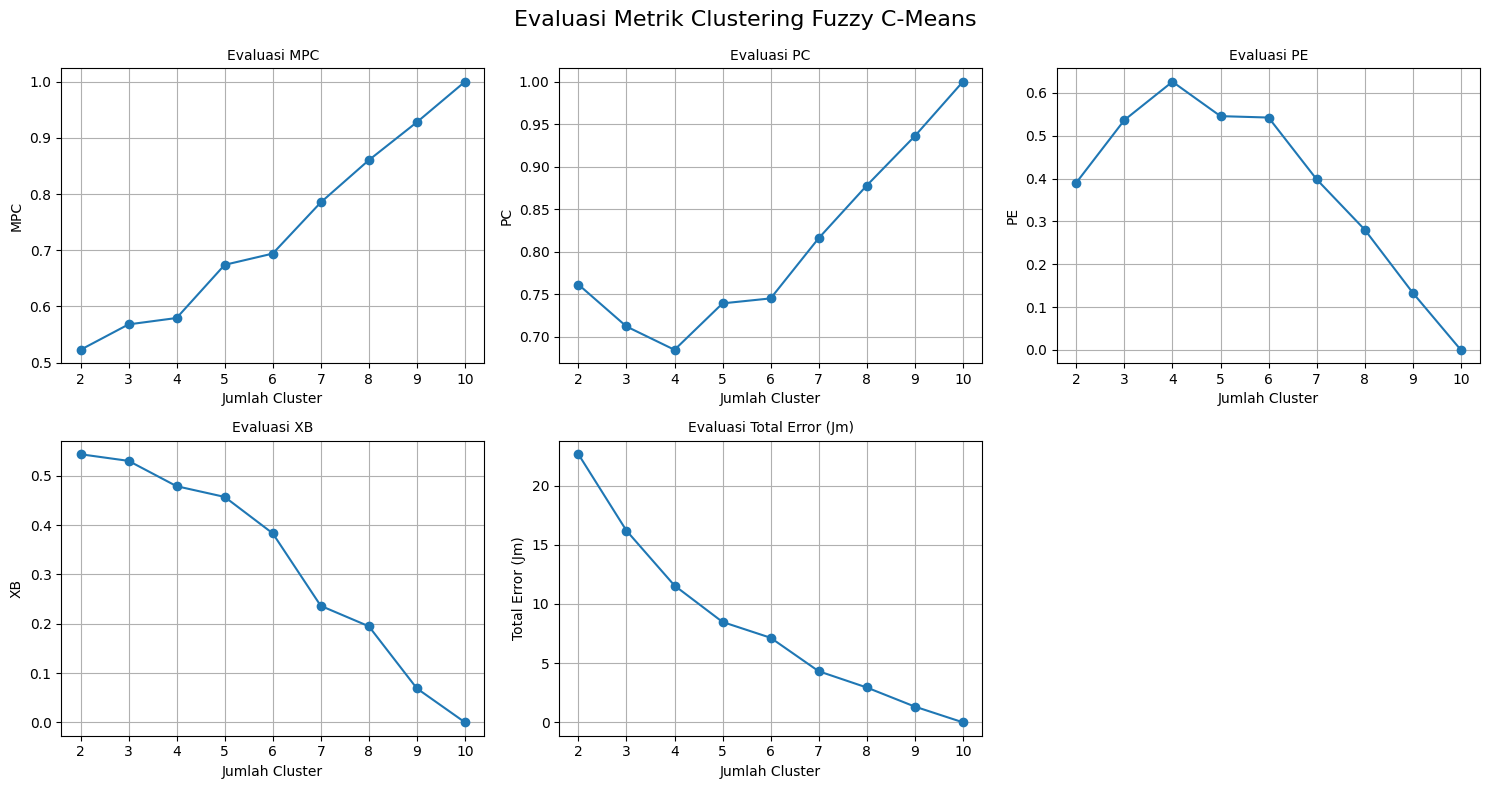

In [28]:
visualisasi_evaluasi(df_evaluasi_model)

Pada seluruh matriks evaluasi internal yang dilakukan sebanyak 5 cluster, didapatkan jumlah cluster yang optimal pada model ini, yaitu sebanyak 3 cluster. Pada MPC dan FPC menunjukkan hasil yang baik di atas 85%, sedangkan pada PE dan error fungsi objektif berada pada global error, meskipun pada XB bukan angka minimum error, sudah menunjukkan hasil yang sangat baik.

## Interpretasi Model

Pada bagian ini, akan diambil jumlah cluster 3 untuk menampilkan hasil evaluasi dan interpretasi yang paling baik

In [29]:
def fcm_model_tunggal(data, c, columns_name=drop_columns, m=1.5, error=0.005, maxiter=100):
    """
    Pelatihan Fuzzy C-Means pada satu set data dan sekali pelatihan.

    Parameters:
    - data: DataFrame atau array dengan shape (n_samples, n_features)
    - c: jumlah cluster
    - m: derajat fuzziness
    - error: toleransi error
    - maxiter: maksimal iterasi

    Returns:
    - df_evaluasi_cluster: DataFrame evaluasi cluster
    - df_result: DataFrame berisi keanggotaan cluster
    - df_centroid: DataFrame centroid hasil clustering
    """
    result_eval = []

    # if isinstance(data, pd.DataFrame):
    #     drop_columns = data.columns.tolist()
    #     data_array = data.values
    # else:
    #     data_array = data
    #     # drop_columns = [f"Fitur {i}" for i in range(data_array.shape[0])]  # fallback name

    # # Transpose jika perlu agar (features, samples)
    # if data_array.shape[0] < data_array.shape[1]:
    #     data_for_fcm = data_array
    # else:
    #     data_for_fcm = data_array.T

    # Training Fuzzy C-Means
    cntr, u, label, jm = fcm_with_dtw_model(
            data = data,
            c=c,
            m=m,
            error=error,
            maxiter=maxiter)
    # cntr, u, _, jm, p, _, fpc = fuzzy.cluster.cmeans(
    #     data=data_for_fcm,
    #     c=c,
    #     m=m,
    #     error=error,
    #     maxiter=maxiter,
    #     init=None
    # )

    # Evaluasi internal
    mpc_value = compute_mpc(u)
    pc_value = compute_pc(u)
    pe_value = compute_pe(u)
    xb_value = compute_xb(data, cntr, u, m=m)
    jm_final = jm
    
    # Ubah cluster agar dimulai dari 1
    cluster_membership = np.argmax(u, axis=0) + 1

    result_eval.append({
        'Jumlah Cluster': c,
        'MPC': mpc_value,
        'PC': pc_value,
        'PE': pe_value,
        'XB': xb_value,
        # 'Iterasi': len(p),
        'Total Error': jm_final
    })

    # DataFrame hasil evaluasi cluster
    df_evaluasi_cluster = pd.DataFrame(result_eval)

    # DataFrame hasil cluster
    df_result = pd.DataFrame({
        'Bahan Pangan': columns_name,
        'Anggota Cluster': cluster_membership
    })

    # Tambahkan derajat keanggotaan
    for i in range(c):
        df_result[f"Cluster {i+1}"] = np.round(u[i],6)  # label cluster juga dimulai dari 1

    # Data centroid
    # df_centroid = pd.DataFrame(cntr, columns=columns_name[:cntr.shape[1]])
    # df_centroid.index = [f"Cluster {i+1}" for i in range(c)]  # supaya index-nya rapi

    return df_evaluasi_cluster, df_result#, df_centroid

In [30]:
df_evaluasi, df_hasil= fcm_model_tunggal(data_for_fcm, c=5)
df_evaluasi

 16%|████████████▉                                                                    | 16/100 [00:04<00:24,  3.50it/s]


,Jumlah Cluster,MPC,PC,PE,XB,Total Error
0,5,0.673917,0.739133,0.545866,0.457196,8.473694


In [31]:
df_hasil

,Bahan Pangan,Anggota Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Beras,2,0.004501,0.981219,0.003969,0.008903,0.001408
1,Bawang Merah,5,0.077802,0.016418,0.013795,0.056246,0.835739
2,Bawang Putih,3,0.088169,0.020276,0.853915,0.010038,0.027602
3,Cabai Merah,5,0.038330,0.009945,0.009109,0.024351,0.918264
4,Cabai Rawit,5,0.141921,0.030674,0.040156,0.049245,0.738004
5,Daging Sapi,4,0.000924,0.003198,0.000318,0.994094,0.001466
6,Telur Ayam,1,0.786749,0.040945,0.122349,0.022991,0.026966
7,Daging Ayam,1,0.728116,0.047167,0.038143,0.054587,0.131987
8,Minyak Goreng,2,0.036709,0.545055,0.015433,0.378851,0.023952
9,Gula Pasir,3,0.014574,0.007488,0.971824,0.002380,0.003734


In [32]:
# df_centroid

### Visualisasi Interpretasi

In [33]:
def visualisasi_hasil_cluster(df_data, df_cluster, title='Diagram Garis Harga Bahan Pangan', datetime_col='Tanggal', nama_bahan_col='Bahan Pangan', cluster_col='Anggota Cluster'):
    """
    Fungsi visualisasi hasil harga bahan pangan dengan jumlah clusternya
    Parameter:
    df_data: dataFrame berisi data time series
    df_cluster: hasil interpretasi cluster

    Output:
    Visualisasi diagram garis dari masing-masing cluster
    """
    
    clusters = df_cluster[cluster_col].unique()

    for cl in sorted(clusters):
        # Ambil nama-nama bahan pangan yang termasuk ke cluster
        bahan_in_cluster = df_cluster[df_cluster[cluster_col] == cl][nama_bahan_col].to_list()

        # Filter kolom di df_data
        col_in_df = [col for col in bahan_in_cluster if col in df_data.columns]

        if not col_in_df:
            print('Kolom tidak ditemukan')
            continue

        figure(figsize=(15,8), dpi=100)

        for col in col_in_df:
            plt.plot(df_data[datetime_col], df_data[col], label=col)

        plt.legend(title='Bahan Pangan', loc='upper left', bbox_to_anchor=(1, 1))
        plt.title(f"{title} - Cluster {cl}", fontsize=18)
        plt.xlabel(datetime_col, fontsize=14)
        plt.ylabel('Harga', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [34]:
def visualisasi_hasil_cluster1(df_data, df_cluster, title,
                               datetime_col='Minggu ke', nama_bahan_col='Bahan Pangan', cluster_col='Anggota Cluster'
                              ):
    """
    Fungsi visualisasi hasil harga bahan pangan dengan jumlah clusternya
    Parameter:
    df_data: dataFrame berisi data time series
    df_cluster: hasil interpretasi cluster

    Output:
    Visualisasi diagram garis dari masing-masing cluster
    """
    clusters = sorted(df_cluster[cluster_col].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), dpi=100)
    axes = axes.flatten()  # Flatten agar akses lebih mudah

    for idx, cl in enumerate(clusters):
        ax = axes[idx]

        # Ambil nama-nama bahan pangan dalam cluster
        bahan_in_cluster = df_cluster[df_cluster[cluster_col] == cl][nama_bahan_col].to_list()
        col_in_df = [col for col in bahan_in_cluster if col in df_data.columns]

        if not col_in_df:
            print(f'Kolom tidak ditemukan untuk Cluster {cl}')
            ax.set_visible(False)
            continue

        for col in col_in_df:
            ax.plot(df_data[datetime_col], df_data[col], label=col)

        ax.set_title(f"Cluster {cl}", fontsize=14)
        ax.set_xlabel(datetime_col)
        ax.set_ylabel('Harga')
        ax.legend(title='Bahan Pangan', loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True)

    # Sembunyikan axis kosong (jika jumlah cluster < jumlah subplot)
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

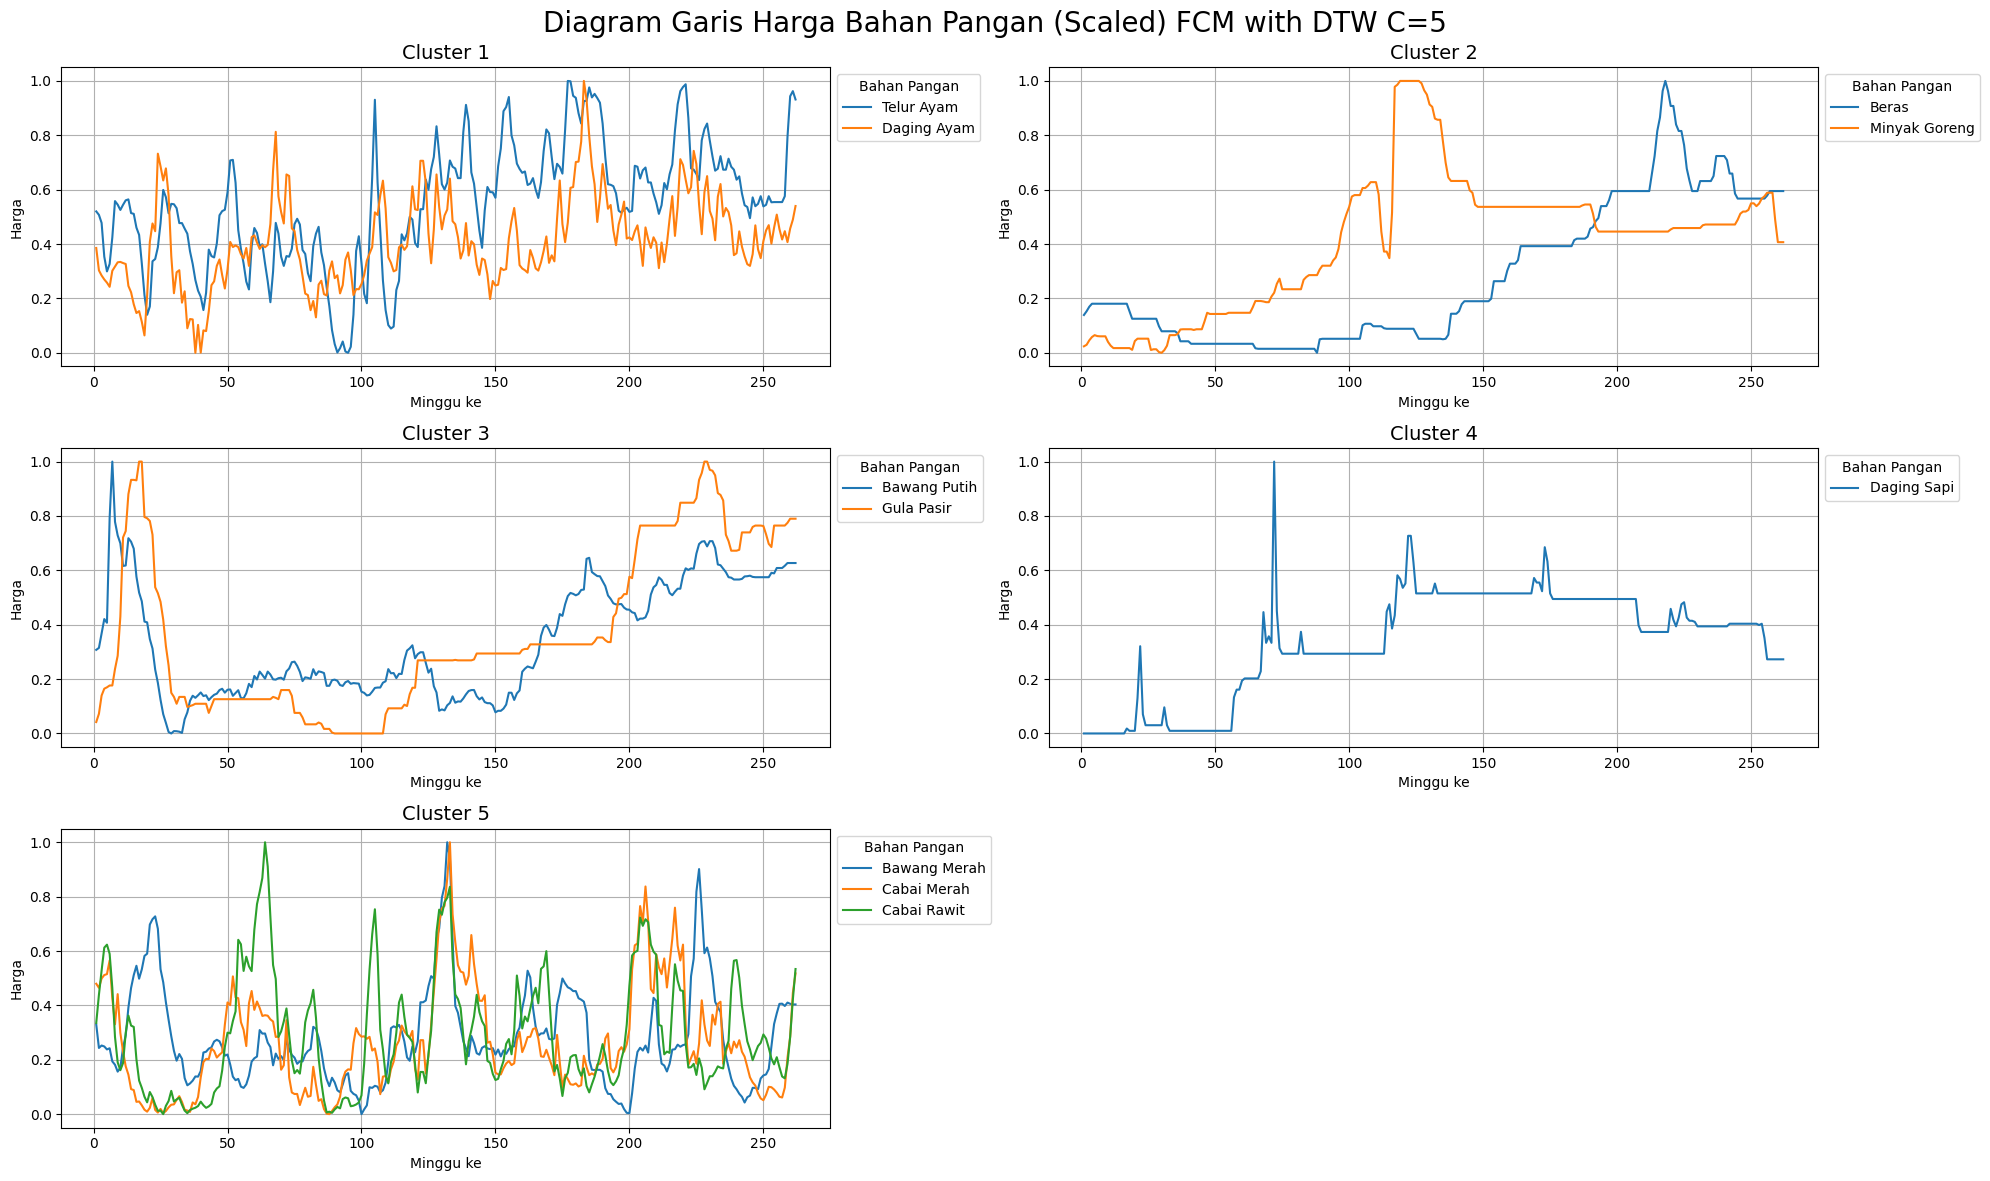

In [35]:
visualisasi_hasil_cluster1(data_scaled, df_hasil, 'Diagram Garis Harga Bahan Pangan (Scaled) FCM with DTW C=5')

Hasil data mingguan hingga Juli 2025 dan harian hingga akhir 2024 memiliki anggota yang sama, pakai jumlah cluster 3 juga karena data poin yang digunakan hanya 10. Apabila jumlah cluster melebihi 50% dari data poin akan menghasilkan kesimpulan yang sedikit(?)

## Interpretasi C=6

In [36]:
df_evaluasi_3, df_hasil_3 = fcm_model_tunggal(data_for_fcm, c=3)
df_evaluasi_3

 27%|█████████████████████▊                                                           | 27/100 [00:03<00:09,  8.09it/s]


,Jumlah Cluster,MPC,PC,PE,XB,Total Error
0,3,0.568037,0.712025,0.536581,0.530343,16.185561


In [37]:
df_hasil_3

,Bahan Pangan,Anggota Cluster,Cluster 1,Cluster 2,Cluster 3
0,Beras,1,0.756918,0.056162,0.186920
1,Bawang Merah,2,0.050880,0.918751,0.030369
2,Bawang Putih,3,0.015619,0.028946,0.955434
3,Cabai Merah,2,0.037827,0.935532,0.026641
4,Cabai Rawit,2,0.079091,0.840283,0.080626
5,Daging Sapi,1,0.867984,0.108920,0.023096
6,Telur Ayam,3,0.121146,0.140294,0.738561
7,Daging Ayam,2,0.254082,0.522217,0.223700
8,Minyak Goreng,1,0.685039,0.218582,0.096378
9,Gula Pasir,3,0.033424,0.022880,0.943696


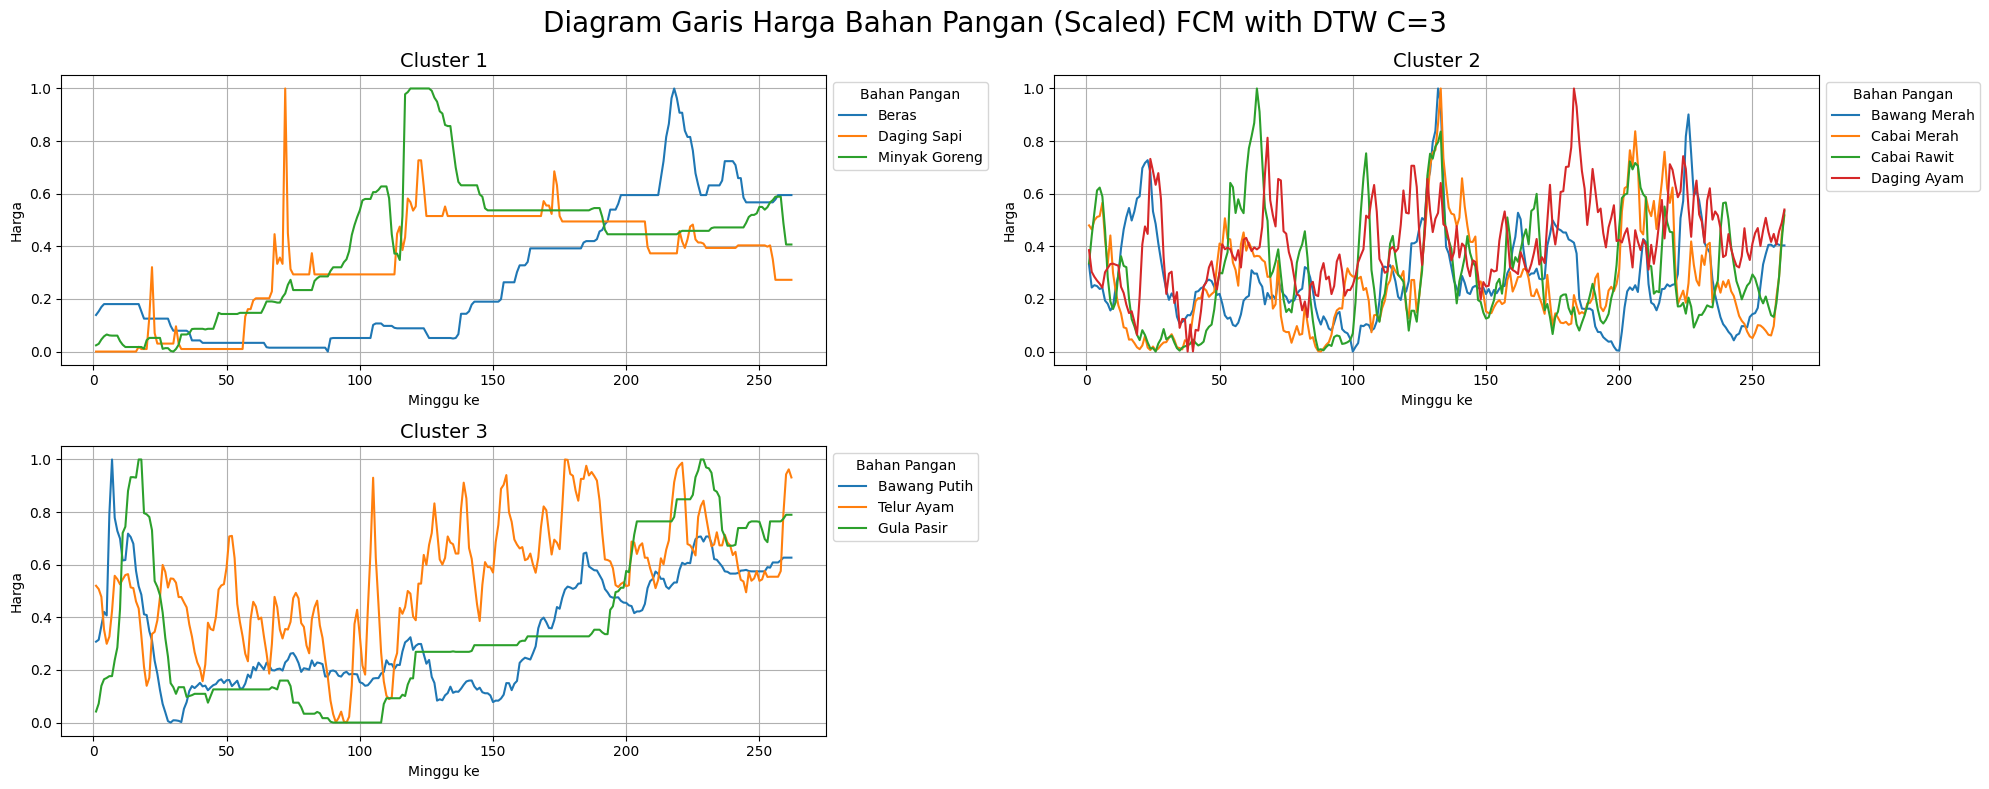

In [38]:
visualisasi_hasil_cluster1(data_scaled, df_hasil_3, 'Diagram Garis Harga Bahan Pangan (Scaled) FCM with DTW C=3')

Di sini.

## Langsung pakai matriks DTW multivariabel

In [41]:
ds = dtw.distance_matrix_fast(data_for_fcm)
ds.shape

(10, 10)

In [42]:
df_ds = fcm_model(ds)
df_ds

 22%|█████████████████▊                                                               | 22/100 [00:00<00:02, 28.60it/s]


,Jumlah Cluster,MPC,PC,PE,XB,Total Error (Jm),Anggota Tiap Cluster
0,2,0.125549,0.562774,0.628304,2.888404e+00,44.2082,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0]"
1,3,0.540190,0.693460,0.568443,5.576841e-01,23.9333,"[1, 0, 2, 0, 0, 1, 2, 1, 1, 2]"
2,4,0.580114,0.685085,0.612830,4.353386e-01,18.0575,"[2, 0, 1, 0, 0, 1, 1, 1, 2, 3]"
3,5,0.578803,0.663042,0.689060,8.297010e-01,14.5032,"[1, 2, 3, 2, 2, 0, 3, 0, 1, 4]"
4,6,0.675618,0.729682,0.585642,3.288405e-01,10.1138,"[2, 3, 1, 3, 4, 0, 1, 0, 2, 5]"
5,7,0.480811,0.554981,1.010123,4.554461e+05,14.1064,"[3, 2, 5, 2, 2, 5, 5, 5, 3, 0]"
6,8,0.850342,0.869049,0.313398,1.955076e-01,4.5123,"[4, 7, 1, 2, 3, 0, 1, 6, 4, 5]"
7,9,0.946981,0.952872,0.122090,9.236370e-02,2.4456,"[0, 2, 7, 5, 3, 1, 8, 4, 0, 6]"
8,10,0.349011,0.414110,1.458988,2.371257e+09,12.5187,"[7, 8, 5, 8, 8, 5, 5, 5, 7, 4]"


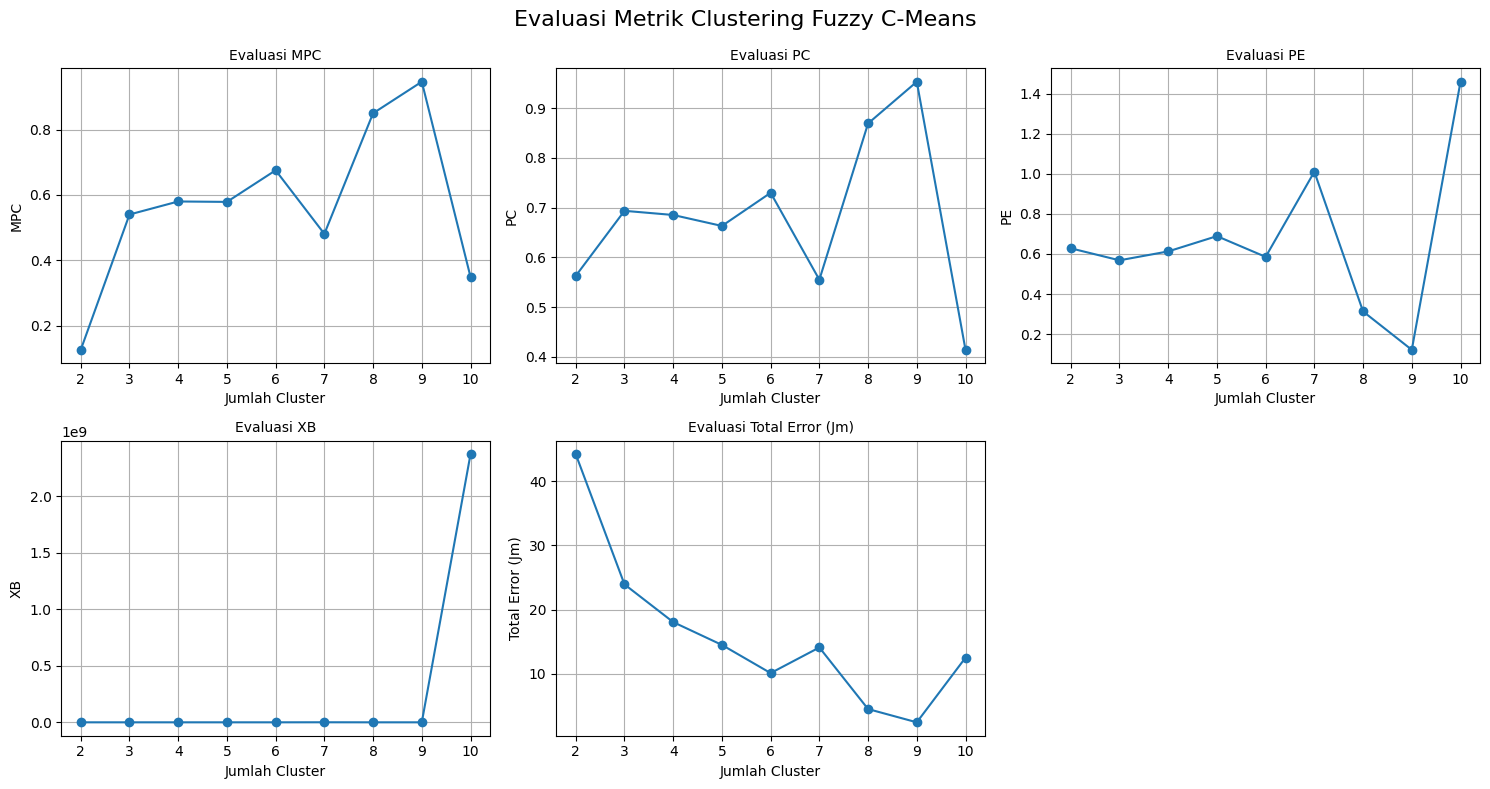

In [43]:
visualisasi_evaluasi(df_ds)

In [ ]:
visualisasi_hasil_cluster1(data_scaled, ds